In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import nan as NaN
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor as gbdt
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from math import sqrt
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from itertools import combinations
import warnings


warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']

df = pd.read_excel('raw_data.xlsx')
df = df.drop(['A组气体流量计5'],axis=1)

# 1.数据探索

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 47 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   时间        7752 non-null   datetime64[ns]
 1   进水COD     7752 non-null   float64       
 2   进水氨氮      7752 non-null   float64       
 3   进水总磷      7752 non-null   float64       
 4   进水总氮      7752 non-null   float64       
 5   进水SS      7752 non-null   float64       
 6   进水PH      7752 non-null   float64       
 7   进水流量      7752 non-null   float64       
 8   出水COD     7752 non-null   float64       
 9   出水氨氮      7752 non-null   float64       
 10  出水总磷      7752 non-null   float64       
 11  出水总氮      7752 non-null   float64       
 12  出水SS      7752 non-null   float64       
 13  出水PH      7752 non-null   float64       
 14  出水流量      7752 non-null   float64       
 15  1#液位计     7752 non-null   float64       
 16  2#液位计     7752 non-null   float64       
 17  1#ORP     7752

In [3]:
df.describe()

进水COD         进水氨氮        进水总磷         进水总氮         进水SS  \
count  7752.000000  7752.000000  7752.00000  7752.000000  7752.000000   
mean    663.395886    18.542032     5.09387    25.064241     3.453888   
std    1357.870897    14.646884     5.10471    10.823681    14.571646   
min       0.990000     0.000000     0.24000     0.000000     0.000000   
25%     130.500000     8.655000     2.75000    20.260000     0.000000   
50%     225.390000    18.305000     3.90000    25.040000     0.000000   
75%     426.900000    24.010000     5.79000    31.070000     1.130000   
max    5500.000000   100.000000    50.00000    50.000000   564.180000   

              进水PH         进水流量        出水COD         出水氨氮         出水总磷  ...  \
count  7752.000000  7752.000000  7752.000000  7752.000000  7752.000000  ...   
mean      7.467438  1553.711149    13.062113     0.184174     0.116383  ...   
std       0.226287   430.654859     6.329341     0.652137     0.150682  ...   
min       6.730000     0.000000     0.000000     0.000000     0.000000  ...   
25%       7.310000  1282.852500    10.560000     0.010000     0.080000  ...   
50%       7.480000  1590.820000    12.855000     0.070000     0.110000  ...   
75%       7.640000  1841.067500    15.040000     0.200000     0.130000  ...   
max       8.060000  2959.310000   100.000000    13.450000    10.000000  ...   

          A组气体流量计1     A组气体流量计2     A组气体流量计3     A组气体流量计4     A组气体流量计6  \
count  7752.000000  7752.000000  7752.000000  7752.000000  7752.000000   
mean    166.553963   288.630504   600.350836   345.414292   342.826664   
std     214.281080    76.847798   157.728234   168.400808   125.277052   
min       0.000000     0.540000     0.000000     0.000000     0.180000   
25%       0.000000   237.630000   472.730000   243.960000   242.105000   
50%       0.000000   266.570000   602.300000   328.600000   332.480000   
75%     368.380000   336.730000   689.560000   384.480000   431.680000   
max    1120.330000   669.490000  1268.270000  1169.520000   801.690000   

          A组气体流量计7     A组气体流量计8     B组气体流量计1     B组气体流量计2        压力变送器  
count  7752.000000  7752.000000  7752.000000  7752.000000  7752.000000  
mean    744.312525   435.509938  1333.780946  1956.076569    75.804098  
std     246.835564   251.215101   398.560237   526.521490     4.265382  
min       0.000000     0.360000     4.340000     3.620000     0.610000  
25%     525.900000   254.630000   996.090000  1459.600000    72.510000  
50%     721.480000   386.100000  1337.530000  2027.635000    74.990000  
75%     957.985000   525.350000  1621.090000  2418.980000    78.220000  
max    1430.840000  2106.120000  2753.910000  3232.780000    85.370000  

[8 rows x 46 columns]

In [4]:
df_drop_time  = df.drop(['时间'],axis=1)

In [5]:
df_corr_matrix = df_drop_time.corr()

In [6]:
df_corr_matrix

进水COD      进水氨氮      进水总磷      进水总氮      进水SS      进水PH  \
进水COD     1.000000  0.093869  0.097005 -0.030011 -0.054996  0.071601   
进水氨氮      0.093869  1.000000 -0.017810  0.135638 -0.024029  0.139991   
进水总磷      0.097005 -0.017810  1.000000  0.163608  0.022764 -0.120671   
进水总氮     -0.030011  0.135638  0.163608  1.000000 -0.028091 -0.084182   
进水SS     -0.054996 -0.024029  0.022764 -0.028091  1.000000 -0.176269   
进水PH      0.071601  0.139991 -0.120671 -0.084182 -0.176269  1.000000   
进水流量      0.123582 -0.028310 -0.147010 -0.241252  0.061037 -0.146785   
出水COD    -0.038600  0.079022  0.092380  0.049258  0.019104 -0.042871   
出水氨氮      0.124279  0.022616  0.033908  0.017690  0.031054 -0.017732   
出水总磷      0.000303 -0.014224  0.031571 -0.044732 -0.000195  0.012072   
出水总氮      0.021089  0.071908  0.000870  0.028028 -0.060025  0.040284   
出水SS      0.010696 -0.063348  0.170900  0.077867  0.023078 -0.152140   
出水PH     -0.135852  0.054290 -0.154004 -0.172220 -0.170778  0.679564   
出水流量      0.092201 -0.031291 -0.122104 -0.205039  0.051828 -0.179039   
1#液位计    -0.210043 -0.145082  0.086032 -0.071864  0.198712 -0.400987   
2#液位计    -0.218455 -0.064459 -0.060514 -0.035245  0.033894 -0.191044   
1#ORP     0.010409  0.186335 -0.011250  0.057783 -0.105898  0.319315   
2#ORP    -0.019622  0.083703  0.021899 -0.050752  0.147686  0.054309   
3#ORP    -0.231083 -0.035158  0.176631  0.087839  0.271139 -0.285660   
4#ORP    -0.261592  0.119005  0.022290  0.160778  0.039126  0.312335   
5#ORP    -0.025868  0.056248 -0.166804 -0.014140 -0.149642  0.200149   
6#ORP    -0.362901 -0.115465  0.052040 -0.011158  0.096897 -0.000065   
7#ORP    -0.267426 -0.059679  0.074945  0.008405  0.146130 -0.040092   
8#ORP    -0.308683 -0.038486  0.014721  0.055457  0.078790  0.051293   
1#DO     -0.046619 -0.128495  0.176524 -0.046232  0.206737 -0.314432   
2#DO      0.009146 -0.016924  0.285813  0.022750  0.024421 -0.084347   
3#DO      0.001472 -0.048565  0.167376  0.022039  0.056967 -0.203402   
4#DO     -0.030931 -0.007290  0.003230  0.015153  0.160069 -0.177019   
5#DO     -0.061179 -0.097989  0.013056 -0.049723  0.061957 -0.178845   
6#DO      0.014323 -0.032737 -0.061771 -0.061216 -0.049475  0.031265   
7#DO     -0.164128 -0.097024 -0.052719 -0.114657 -0.010572 -0.123511   
8#DO     -0.162746 -0.131194  0.080998  0.041029  0.037381 -0.458256   
1#MLSS    0.072971  0.074164 -0.151860 -0.056785 -0.179822  0.385718   
2#MLSS    0.005067 -0.162788  0.008443 -0.133468 -0.008153 -0.305835   
3#MLSS    0.152140  0.138642 -0.001951 -0.010320 -0.165000  0.536927   
4#MLSS    0.024099 -0.068370 -0.025472 -0.068068 -0.022156 -0.128842   
A组气体流量计1 -0.139905 -0.138433  0.238025  0.141572  0.275718 -0.682201   
A组气体流量计2  0.221878  0.014472  0.063532  0.112680 -0.053009 -0.082389   
A组气体流量计3  0.152388 -0.064605  0.187141  0.211155  0.050322 -0.448431   
A组气体流量计4  0.127504 -0.012039  0.041751  0.038152  0.363888 -0.418039   
A组气体流量计6  0.026366 -0.059328  0.151164  0.093511  0.067104 -0.192355   
A组气体流量计7  0.103646 -0.122175  0.176151  0.137080  0.150323 -0.444607   
A组气体流量计8  0.039188 -0.073378  0.011680  0.047331  0.170584 -0.236816   
B组气体流量计1  0.153450 -0.047667  0.134897  0.129762  0.269236 -0.471257   
B组气体流量计2  0.080457 -0.105812  0.135837  0.123104  0.146893 -0.350160   
压力变送器     0.045572 -0.154341  0.142027  0.017589  0.193906 -0.357557   

              进水流量     出水COD      出水氨氮      出水总磷  ...  A组气体流量计1  A组气体流量计2  \
进水COD     0.123582 -0.038600  0.124279  0.000303  ... -0.139905  0.221878   
进水氨氮     -0.028310  0.079022  0.022616 -0.014224  ... -0.138433  0.014472   
进水总磷     -0.147010  0.092380  0.033908  0.031571  ...  0.238025  0.063532   
进水总氮     -0.241252  0.049258  0.017690 -0.044732  ...  0.141572  0.112680   
进水SS      0.061037  0.019104  0.031054 -0.000195  ...  0.275718 -0.053009   
进水PH     -0.146785 -0.042871 -0.017732  0.012072  ... -0.682201 -0.082389   
进水流量      1.000000 -0.001504 -0.003873  0.047122  ...  0.109813  0.500092   
出水COD    -0.

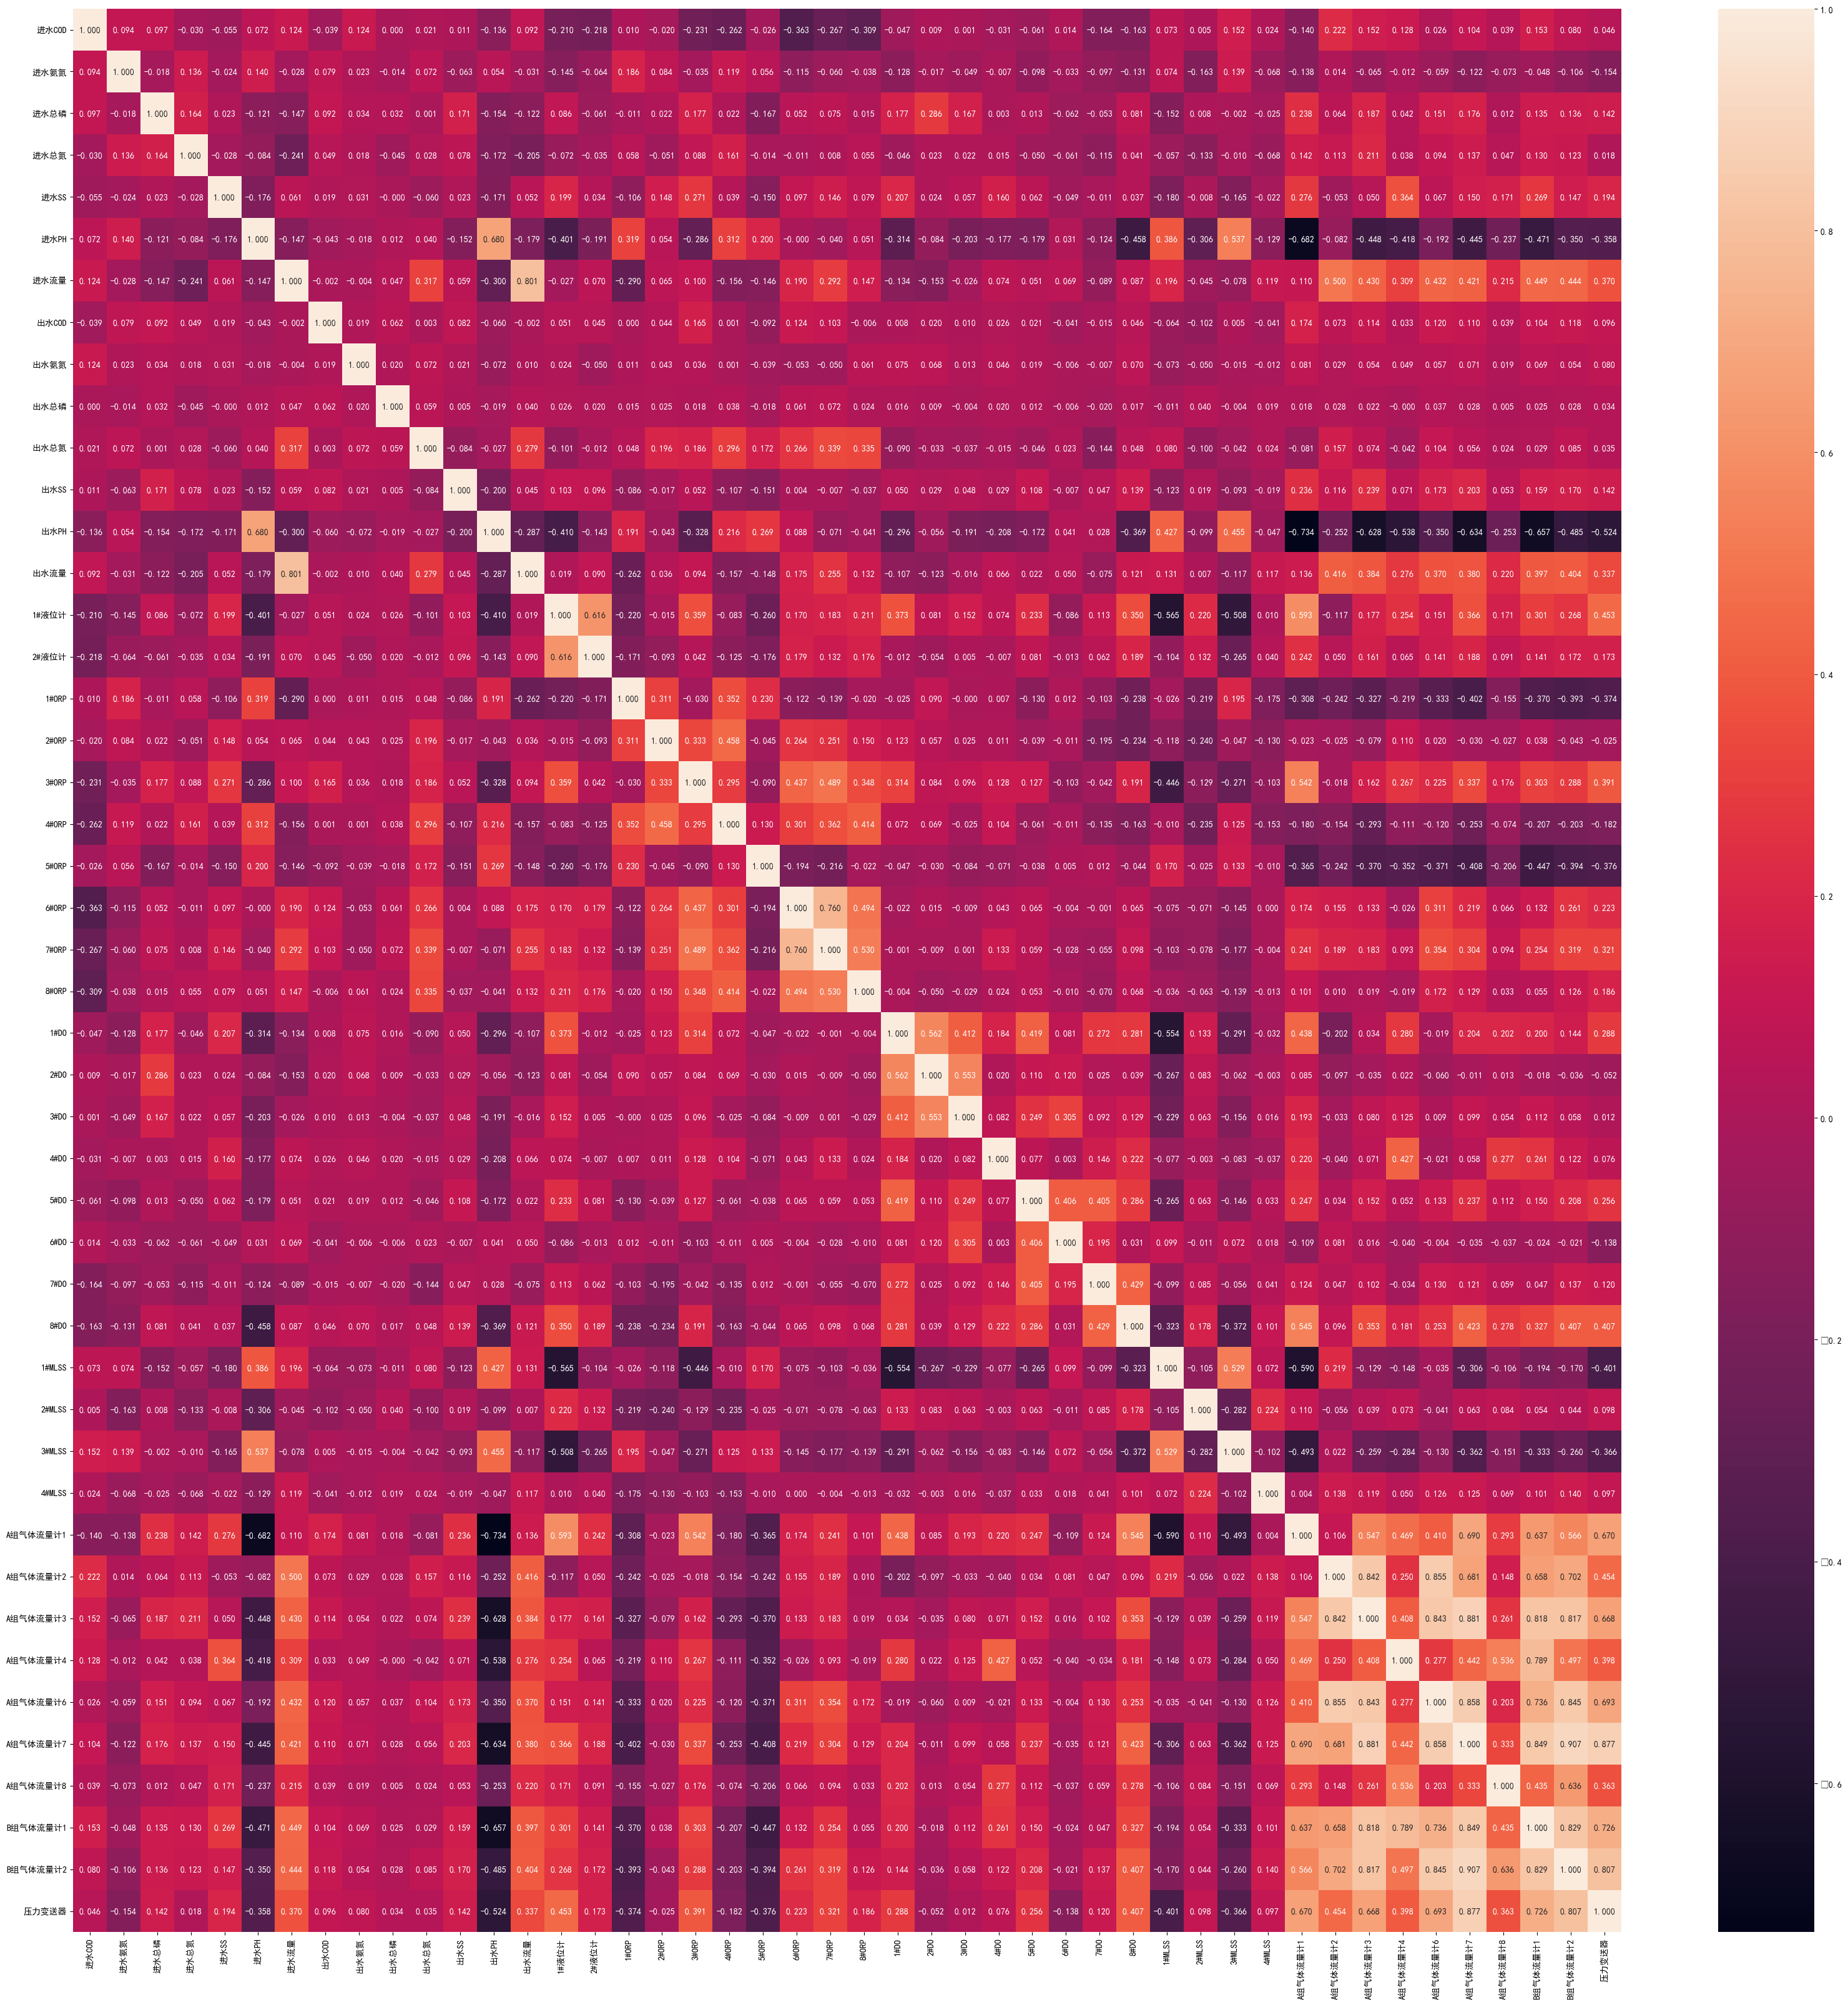

In [7]:
# 显示数值热力图
plt.figure(figsize=(40,40))
sns.heatmap(df_corr_matrix,annot=True,fmt='.3f')
plt.show()

In [8]:
# #箱型图检测异常值
# def box_outliers(ser):
#     #对待检测的数据集进行排序
#     new_ser=ser.sort_values()
#     # 判断数据的总数量是奇数还是偶数
#     if new_ser.count()%2==0 :
#         #计算Q3，Q1,IQR
#         Q3=new_ser[int(len(new_ser)/2):].median()
#         Q1=new_ser[:int(len(new_ser)/2)].median()
#     elif new_ser.count()%2 !=0 :
#         Q3=new_ser[int(len(new_ser)/2-1):].median()
#         Q1=new_ser[:int(len(new_ser)/2-1)].median()
#     IQR=round(Q3-Q1,1)
#     rule=(round(Q3+1.5*IQR,1)<ser) | (round(Q1-1.5*IQR,1)>ser)
#     index=np.arange(ser.shape[0])[rule]
#     #获取异常值及其索引
#     outliers=ser.iloc[index]
#     return outliers
# sa=box_outliers(df['进水SS'])
# sa

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


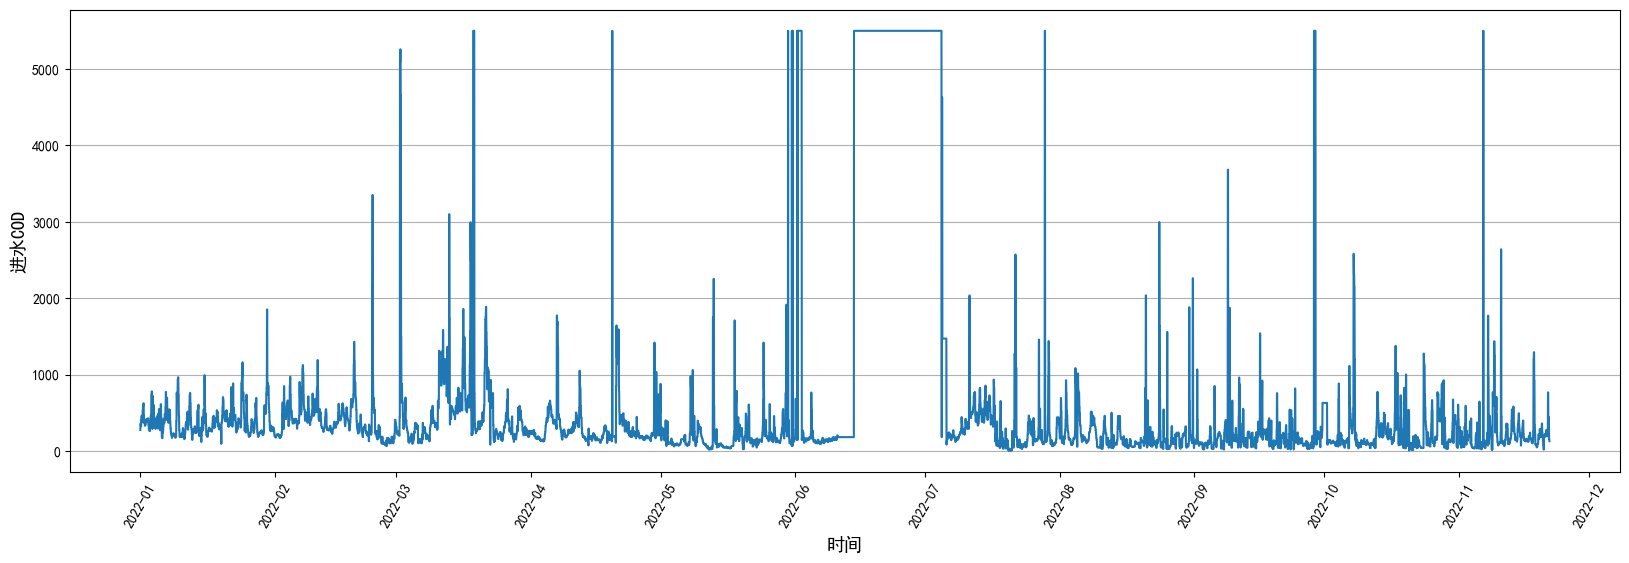

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


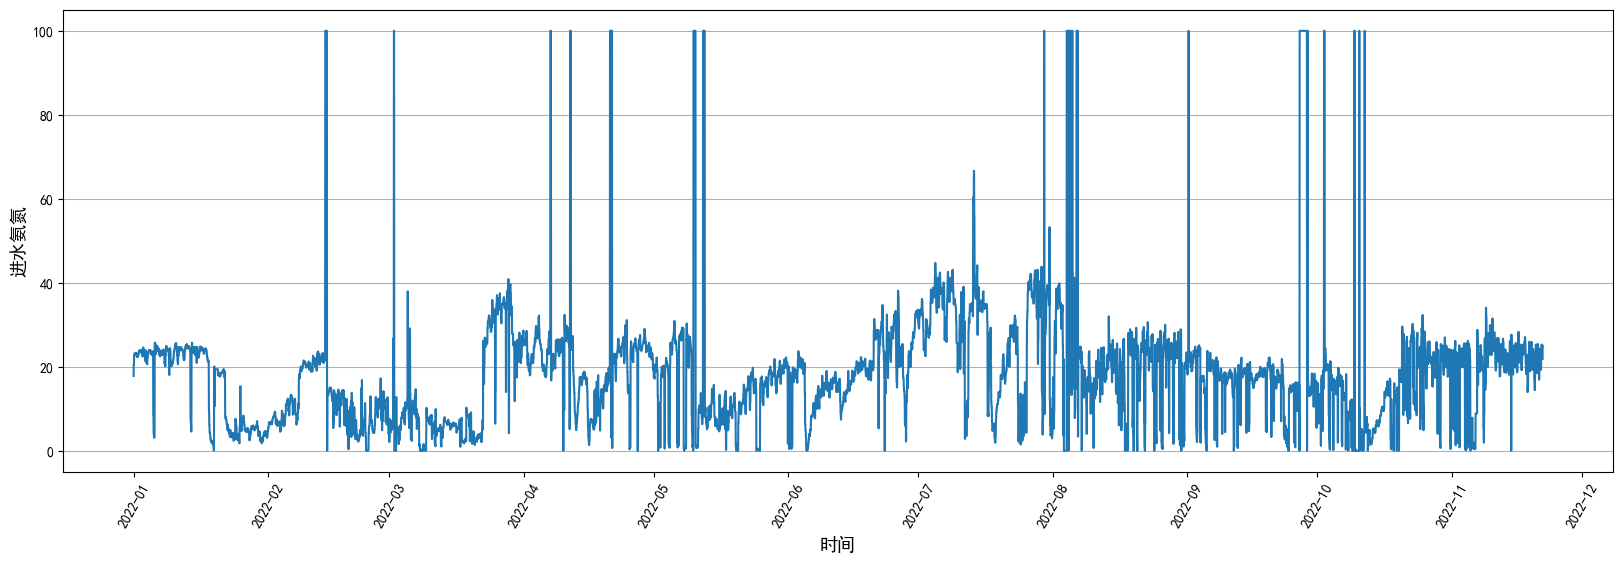

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


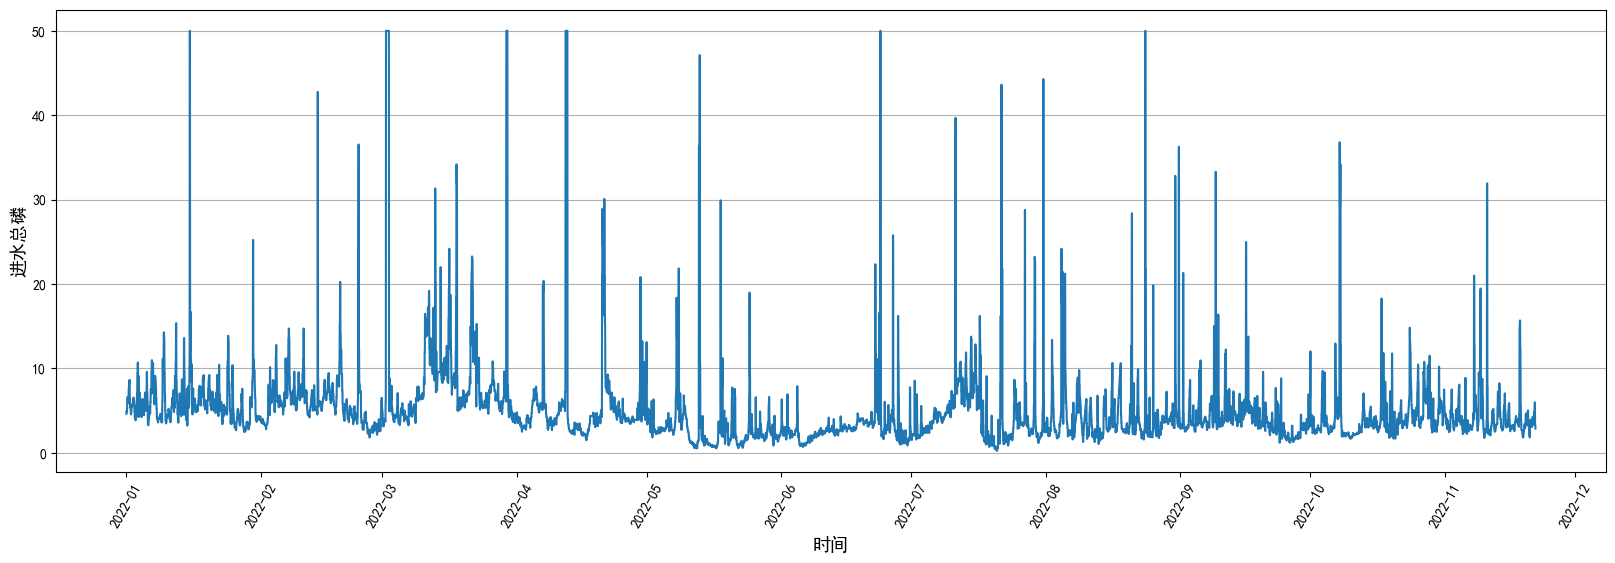

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


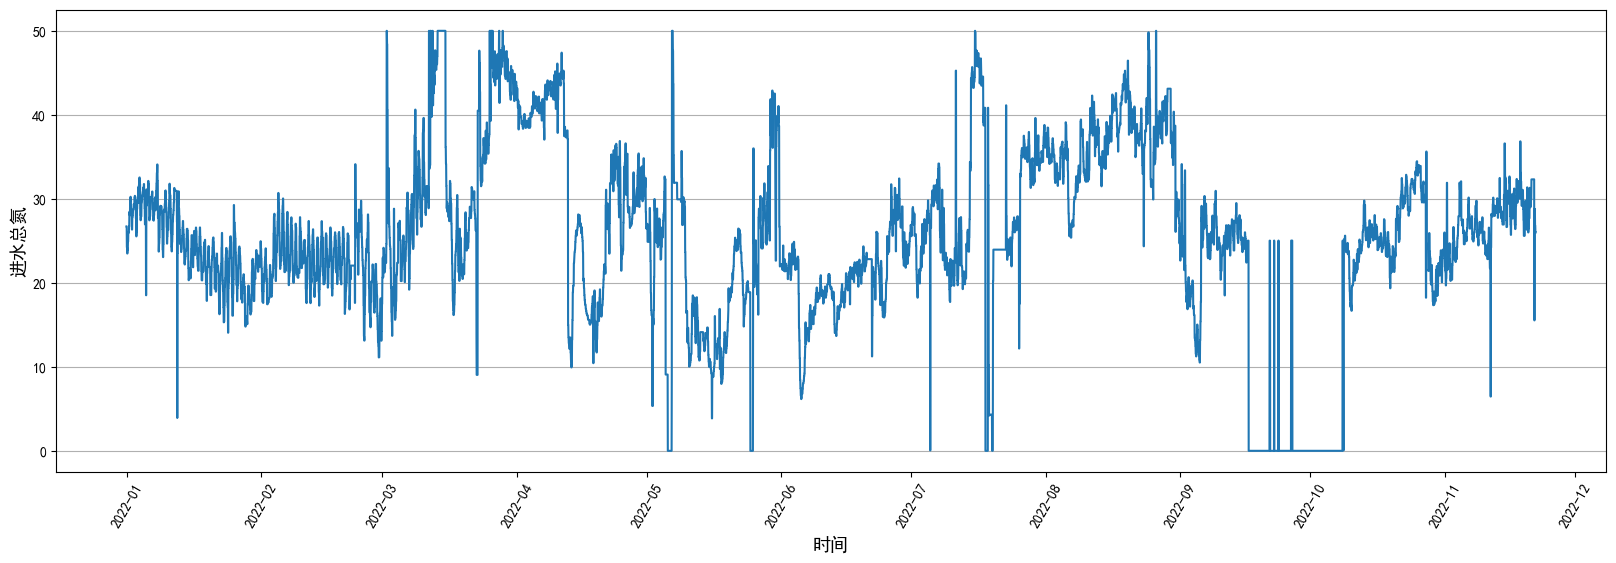

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


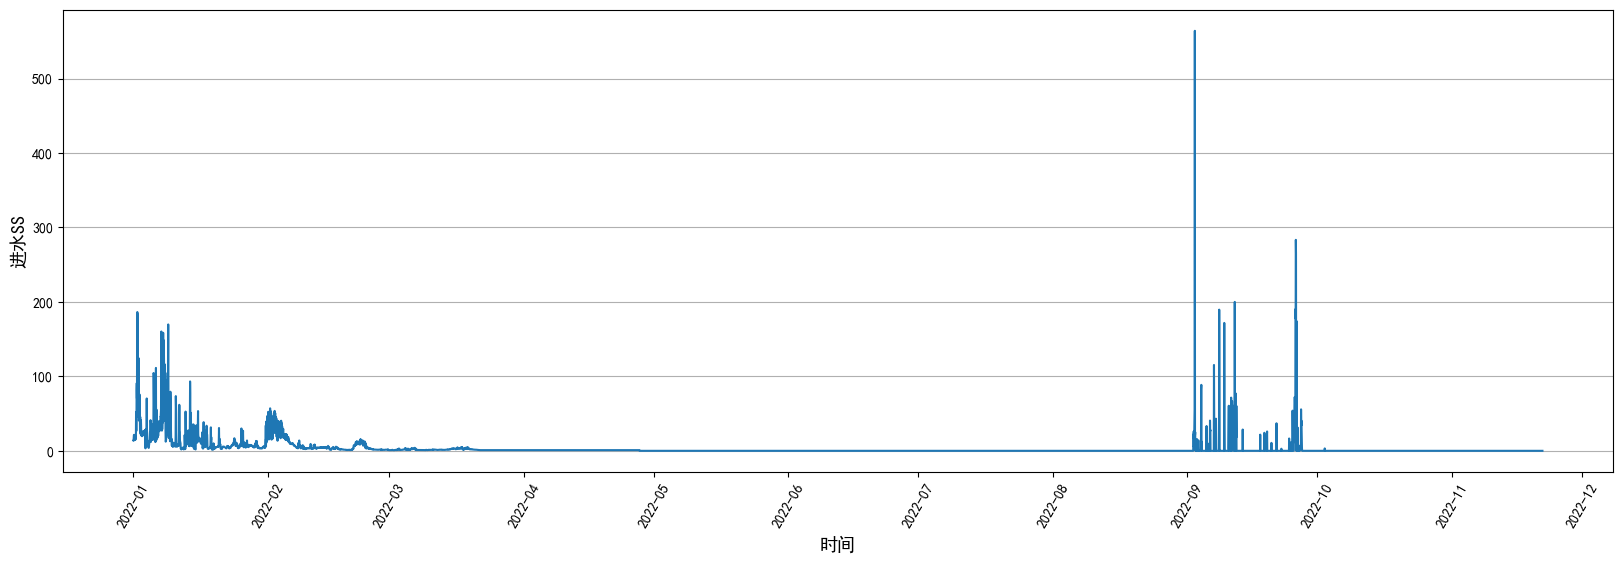

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


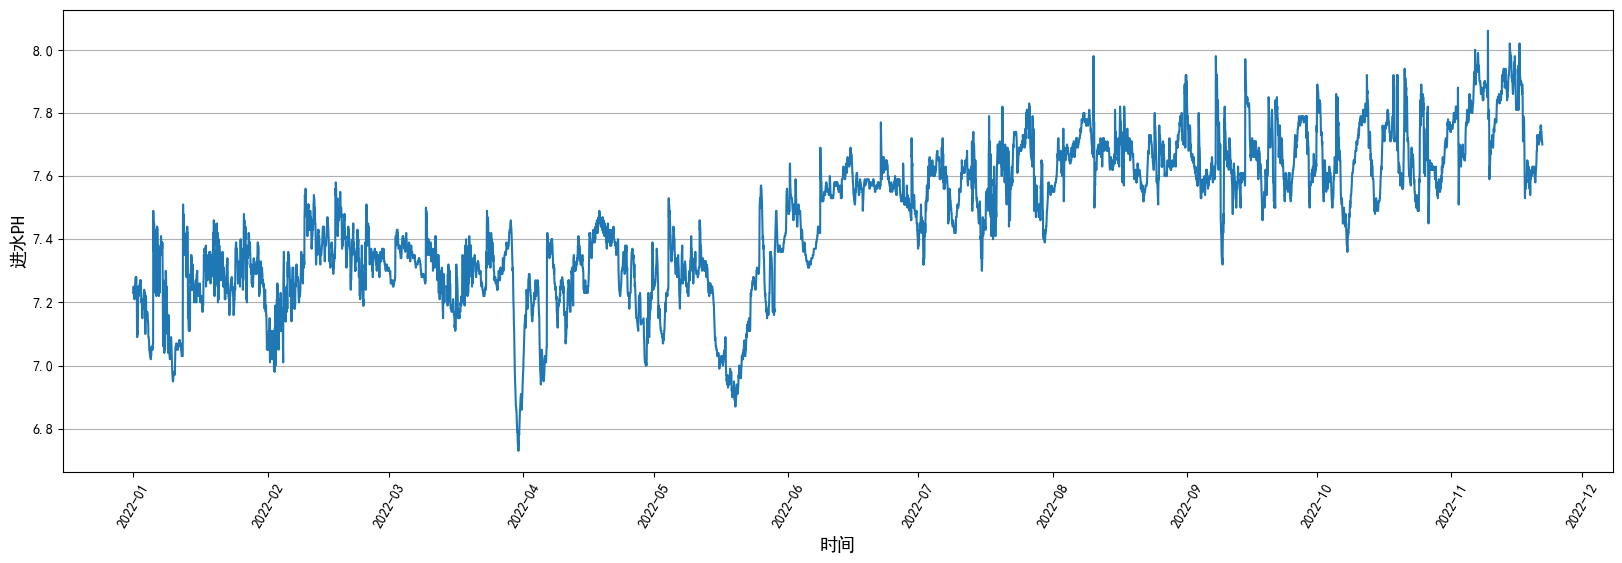

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


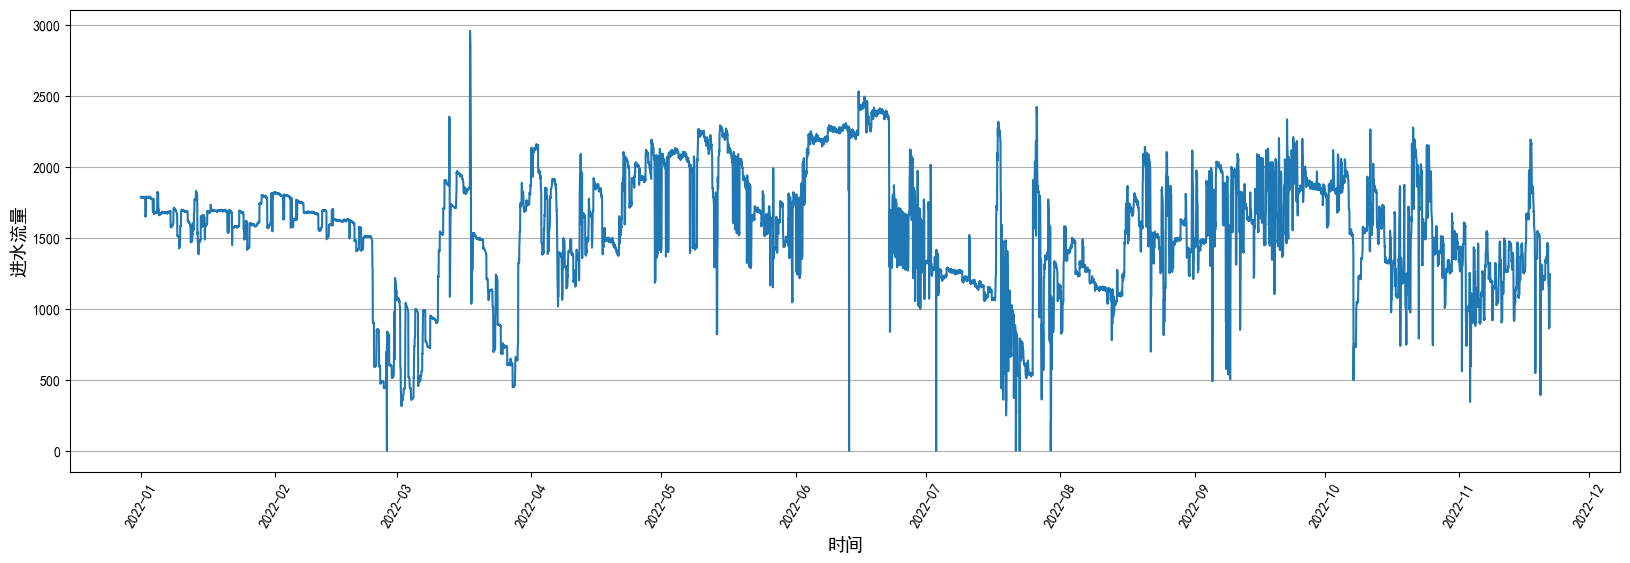

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


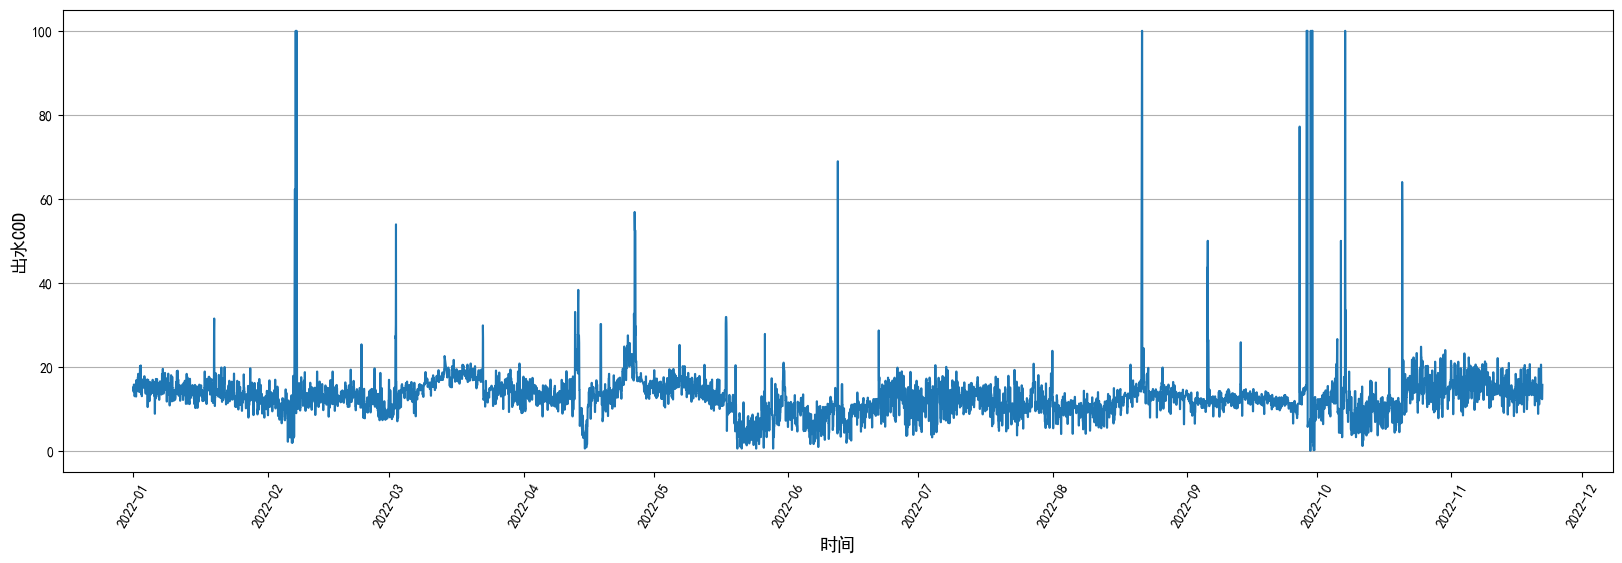

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


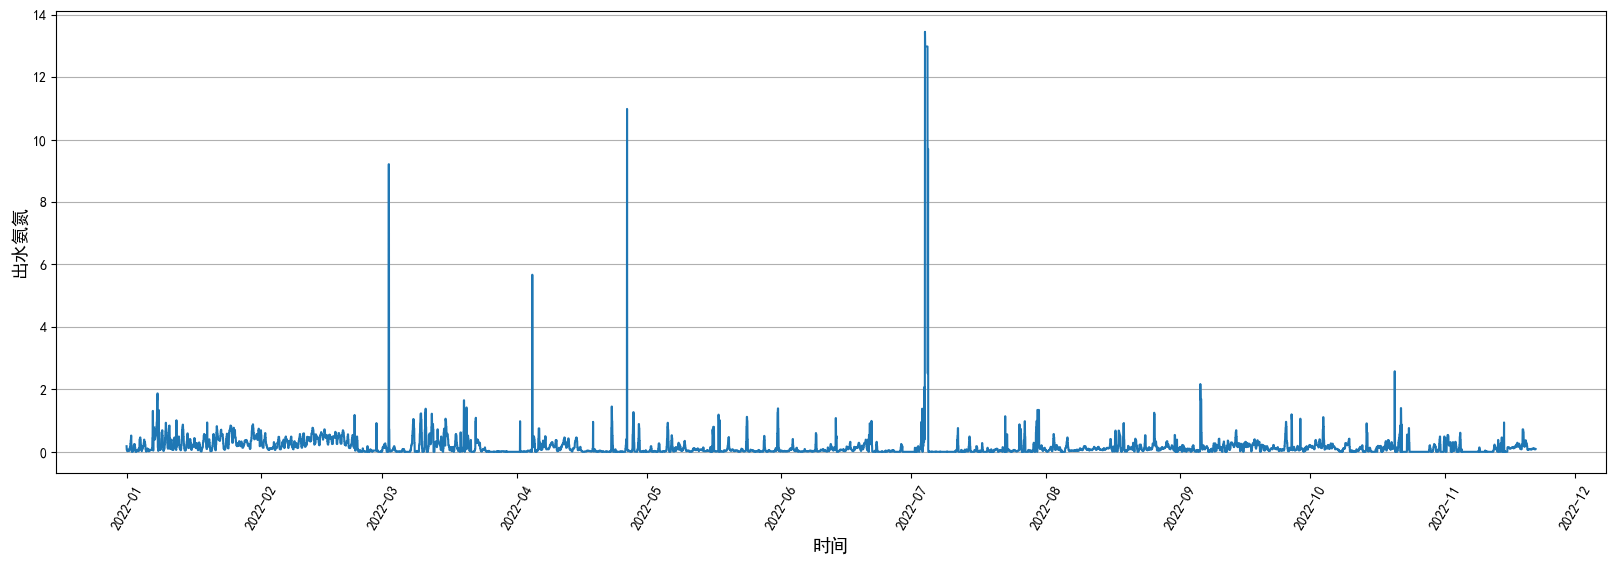

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


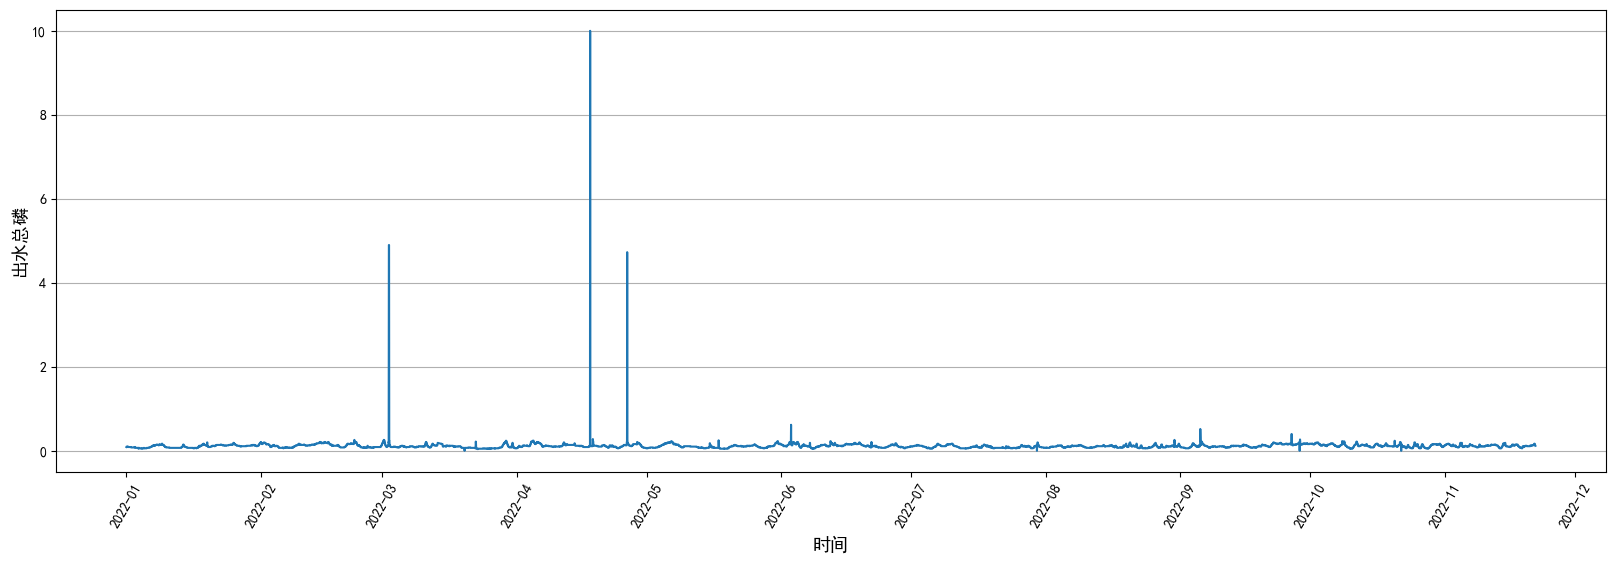

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


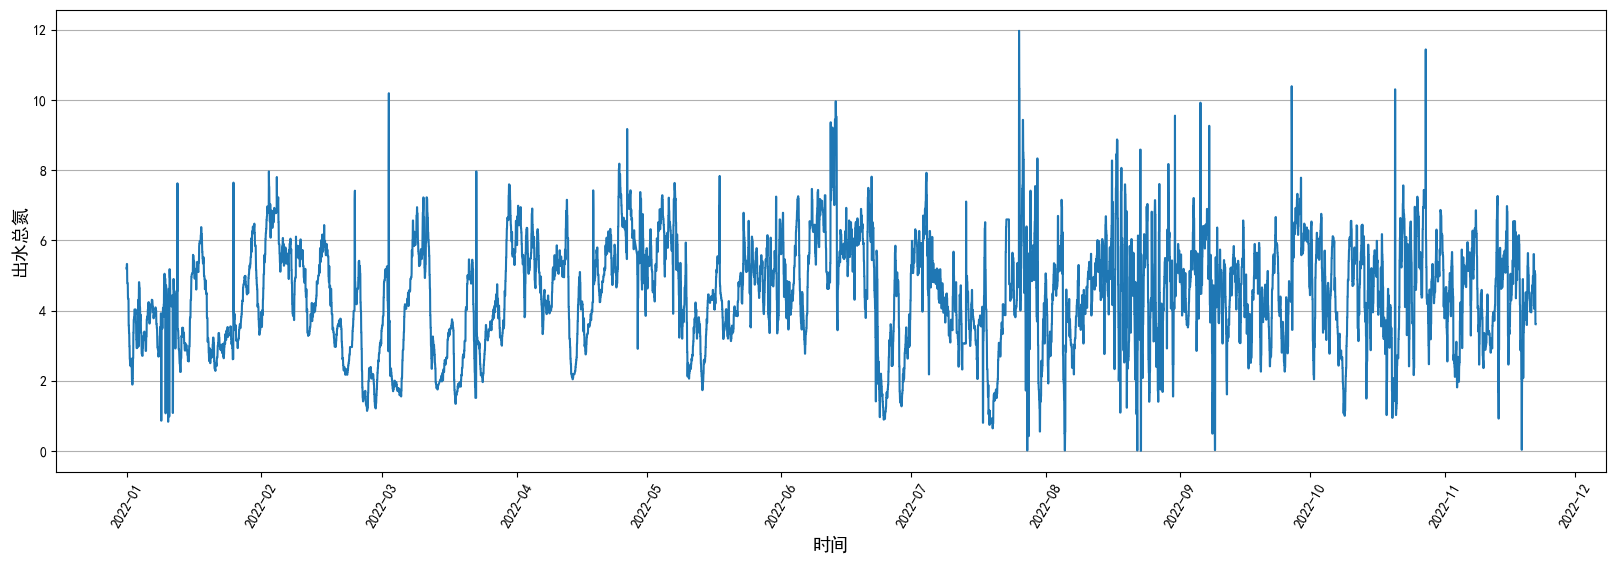

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


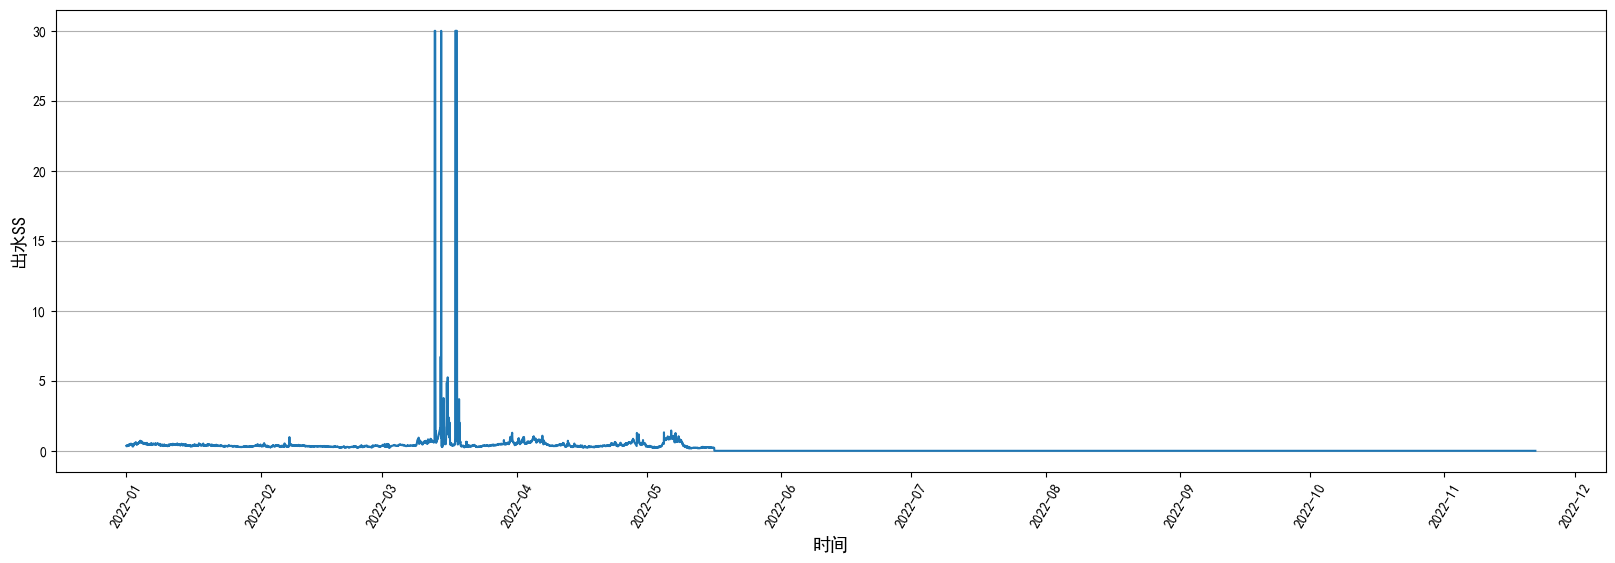

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


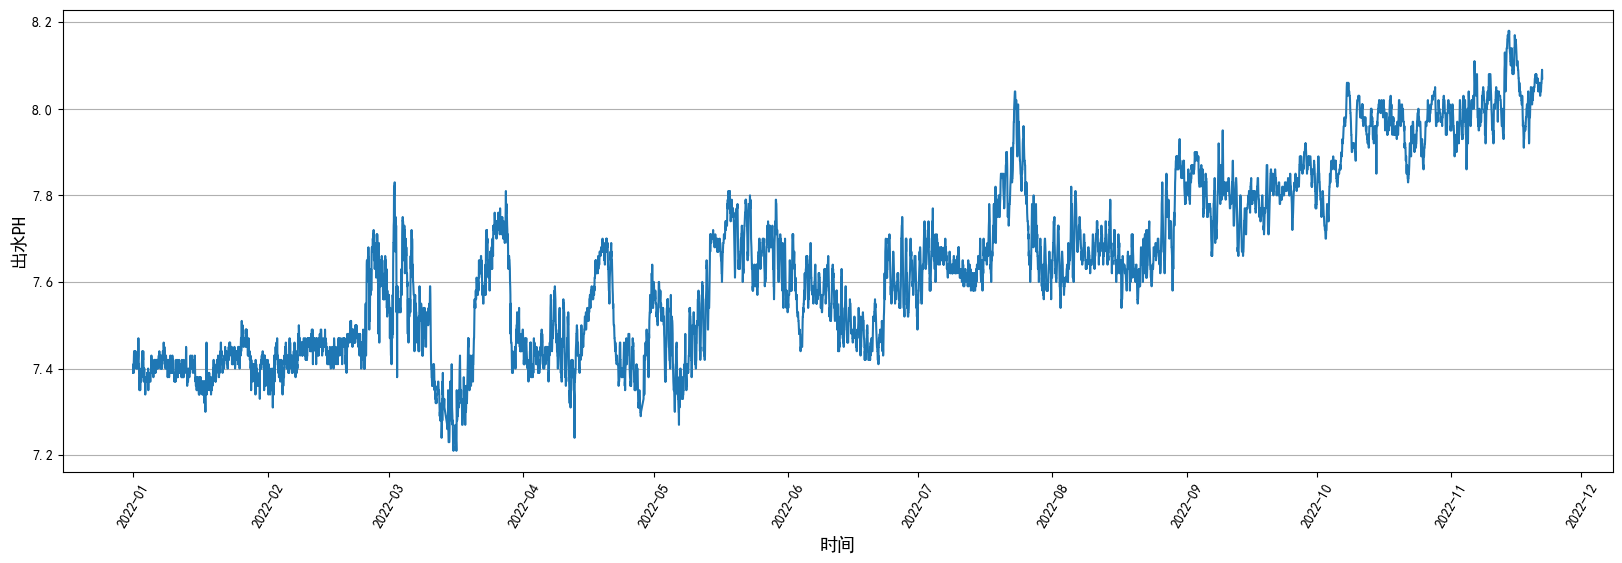

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


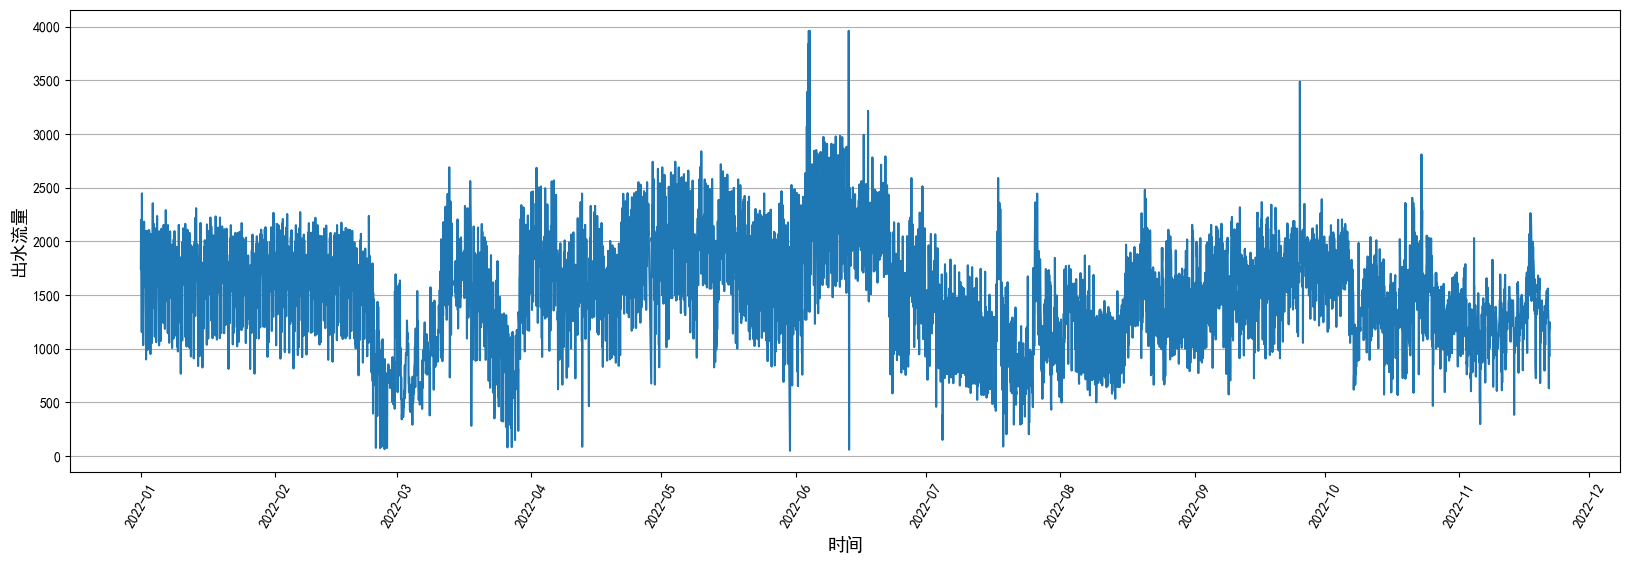

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


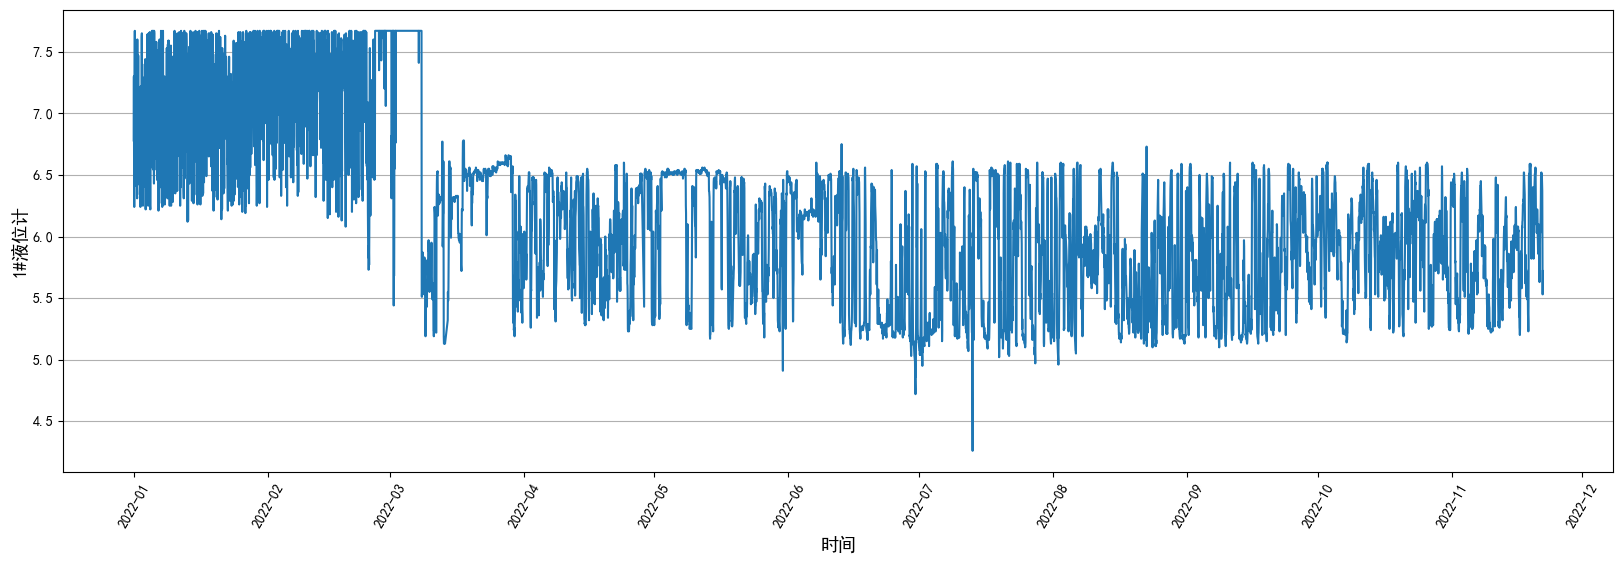

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


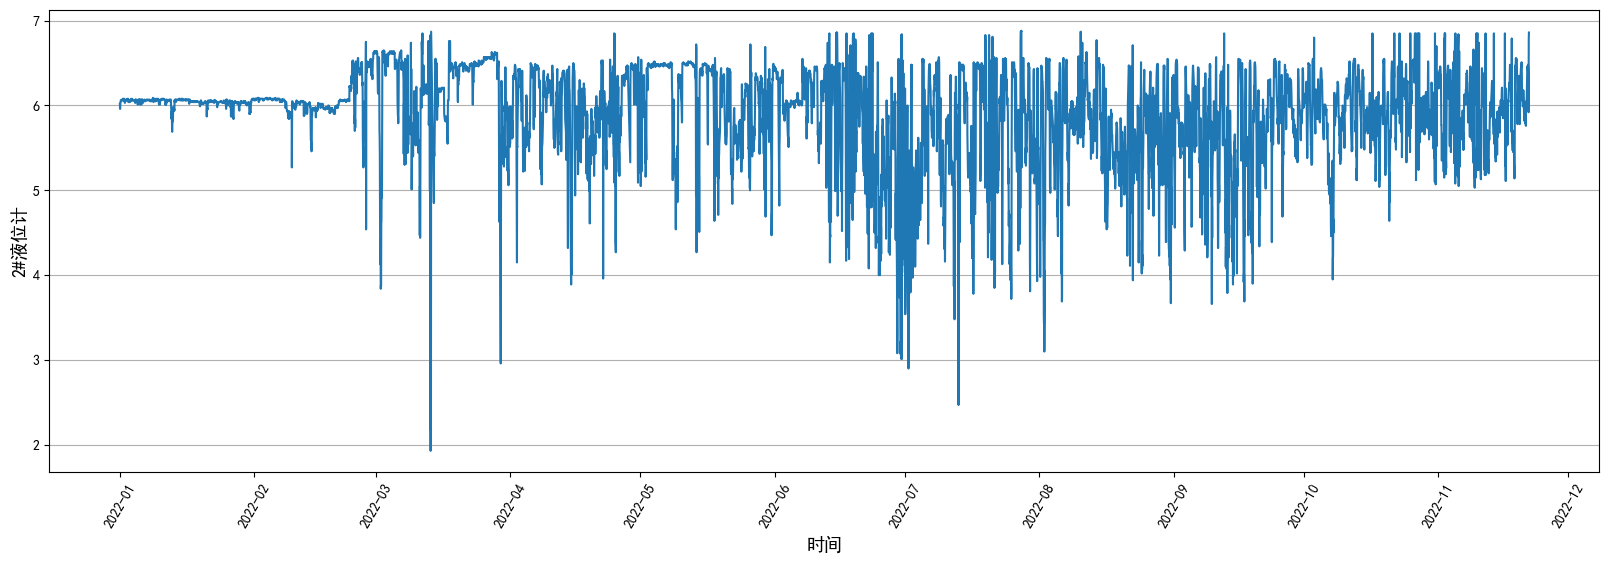

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


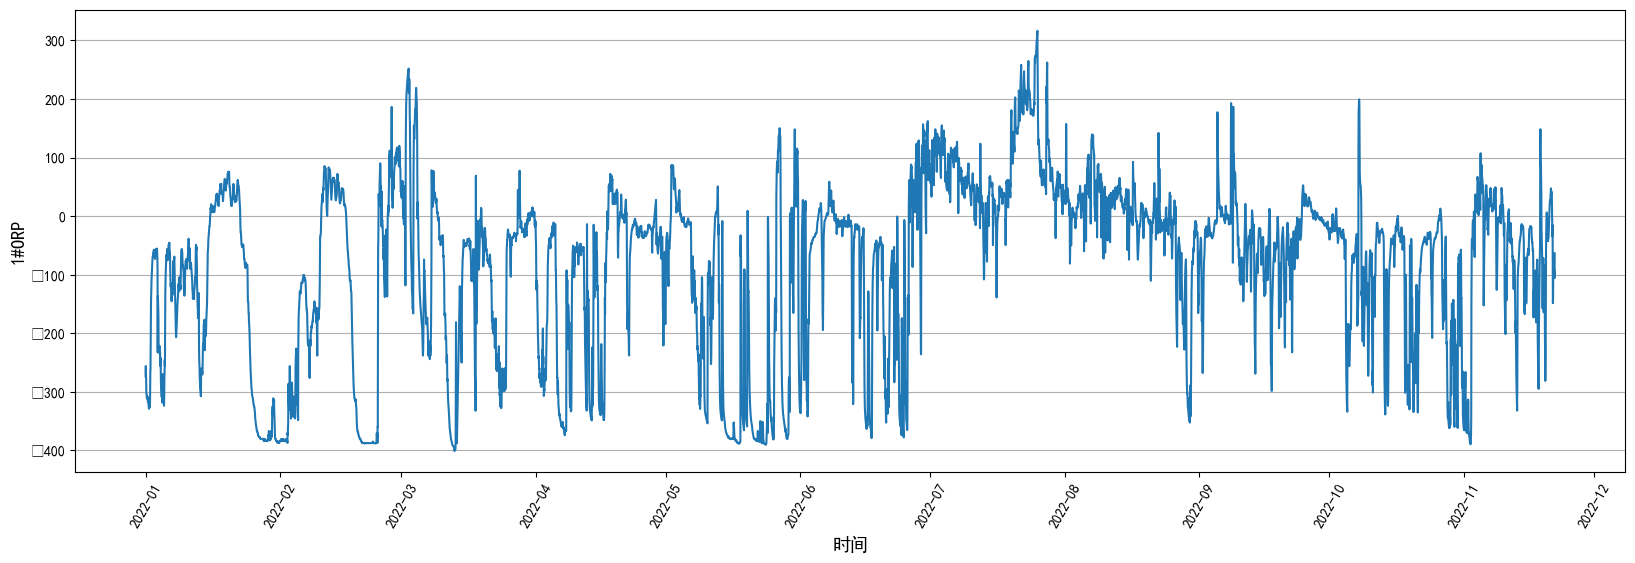

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


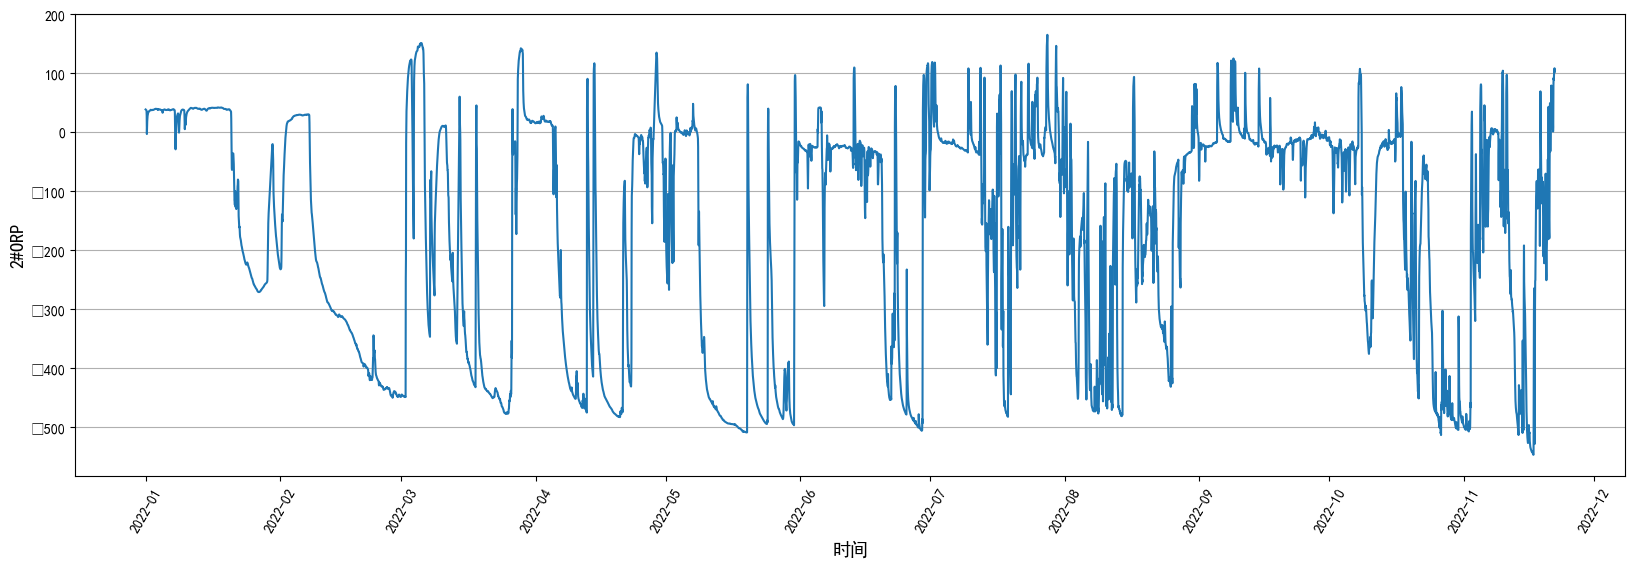

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


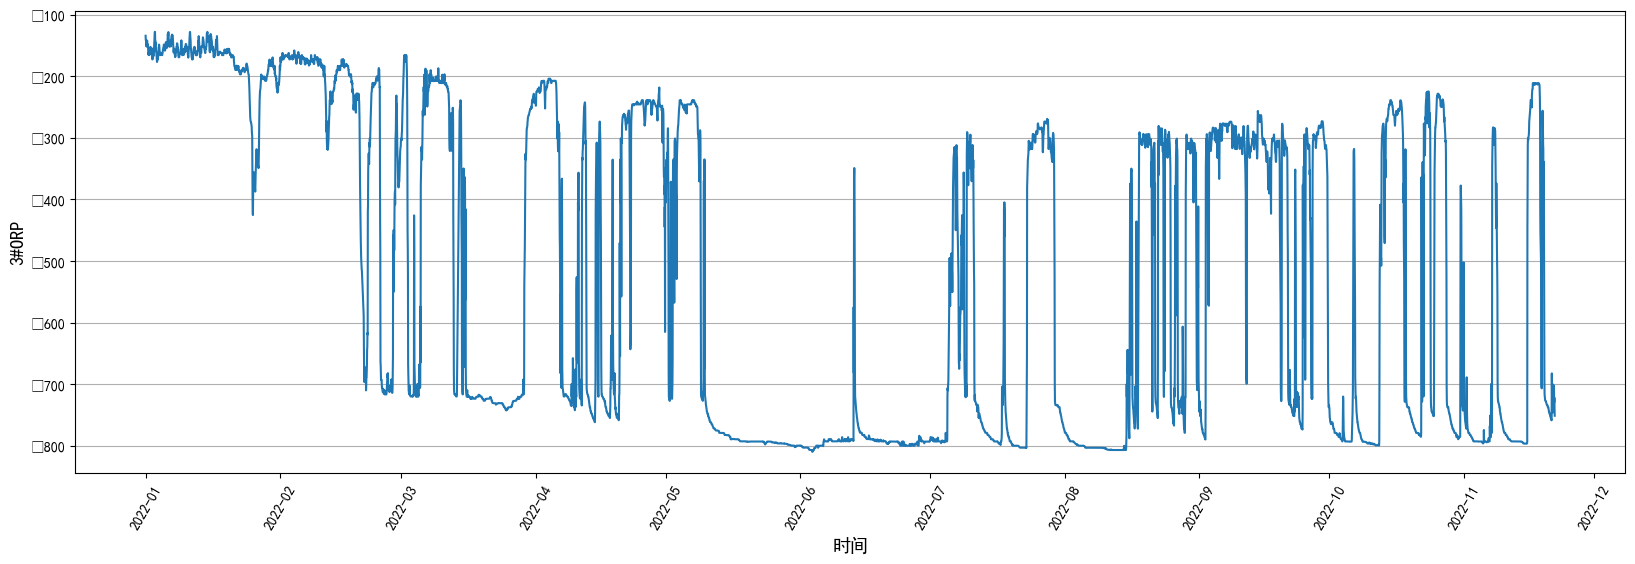

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


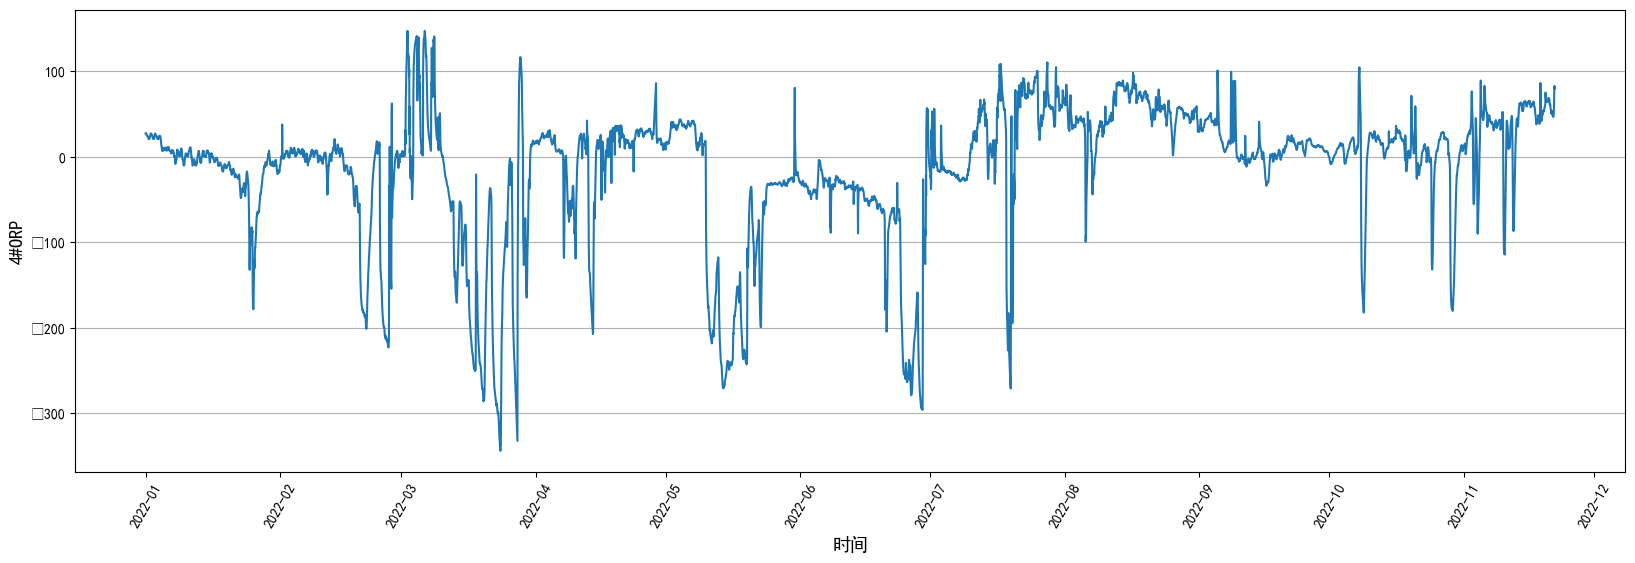

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


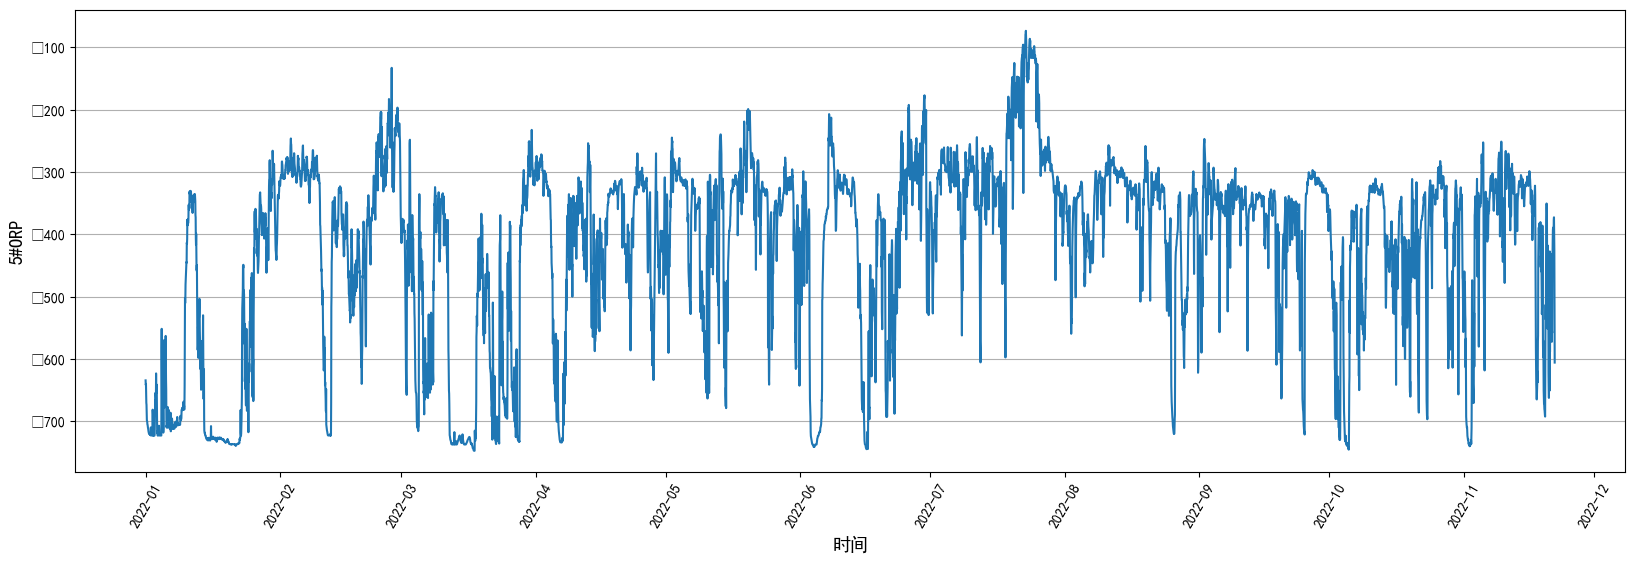

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


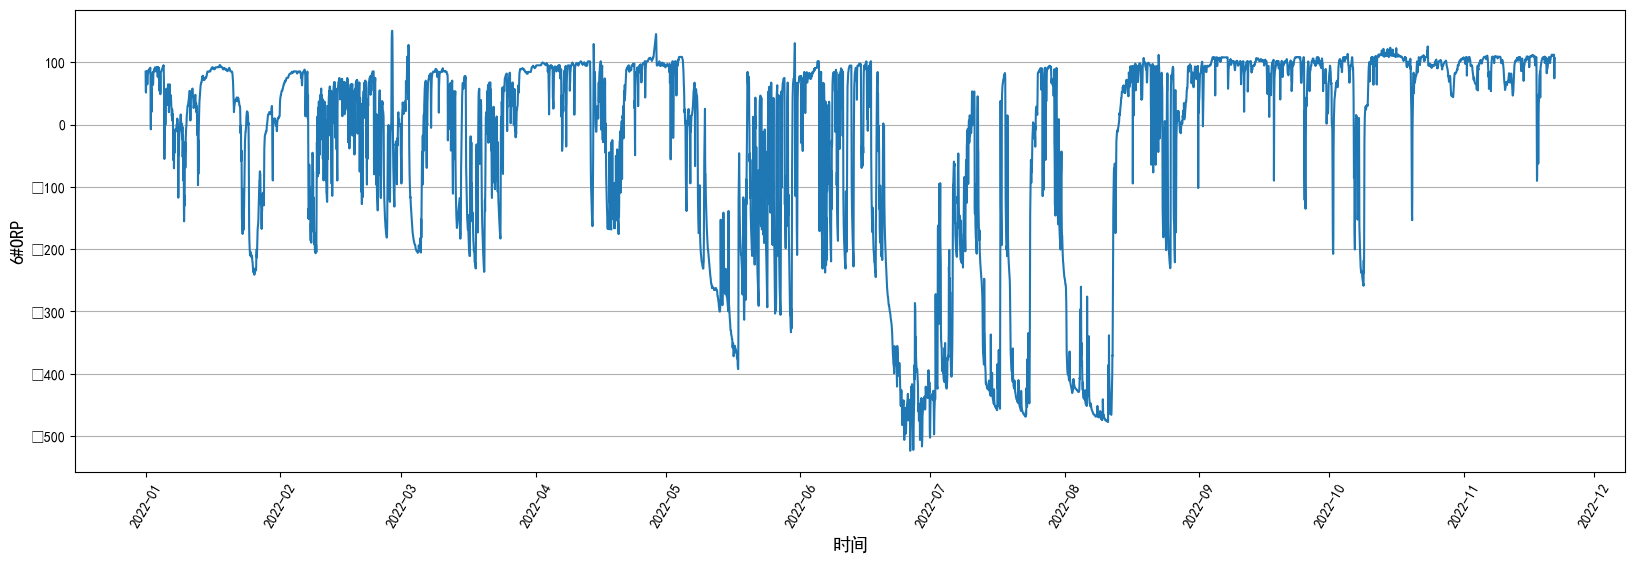

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


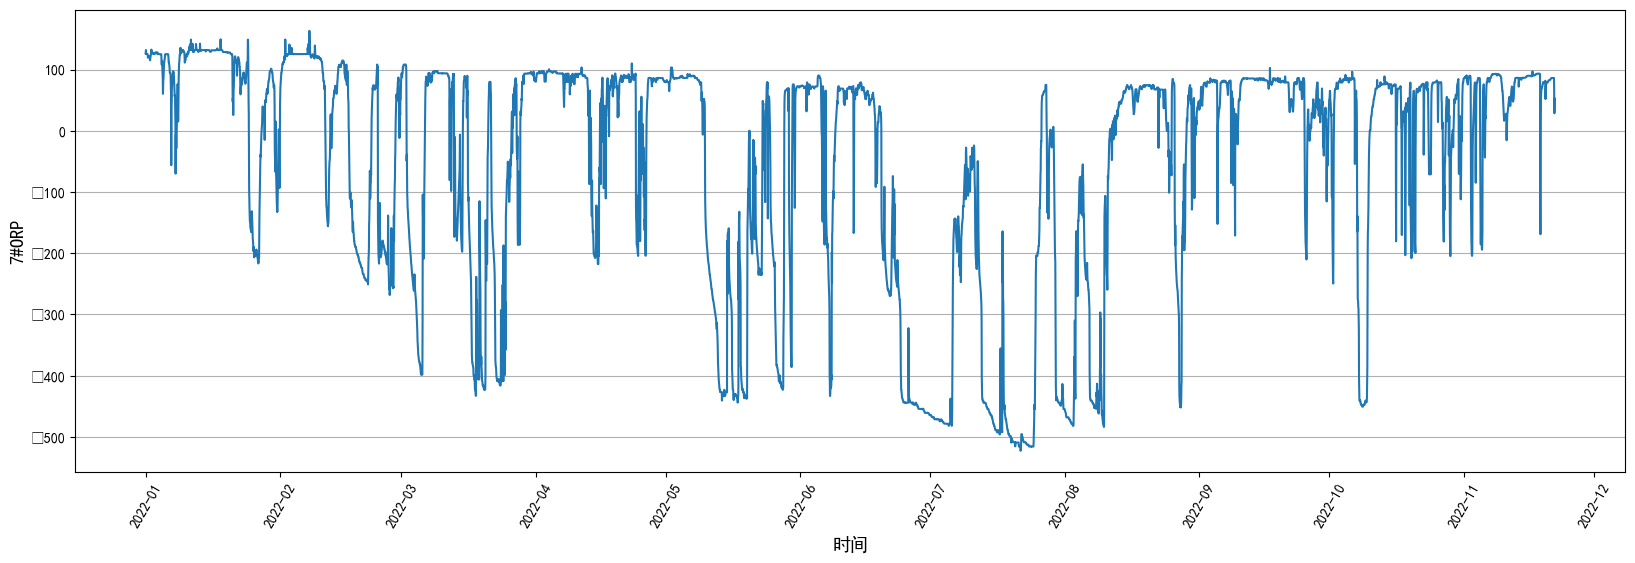

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


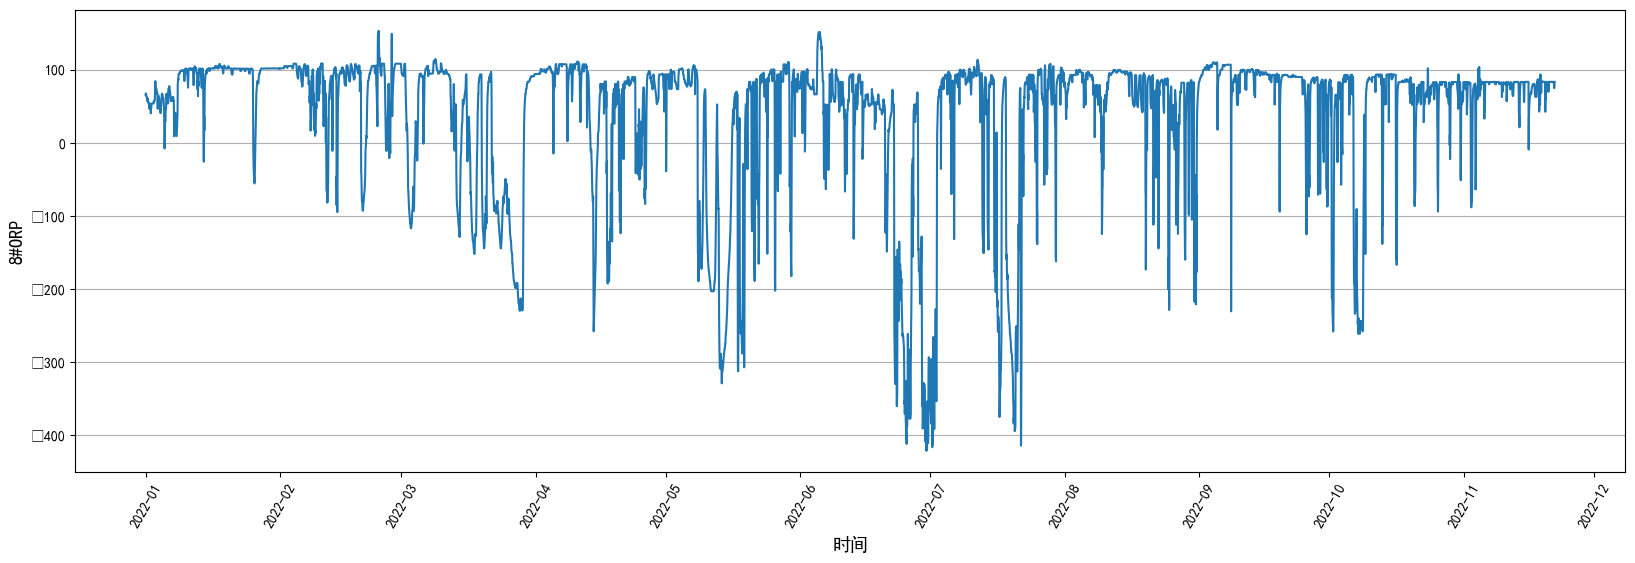

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


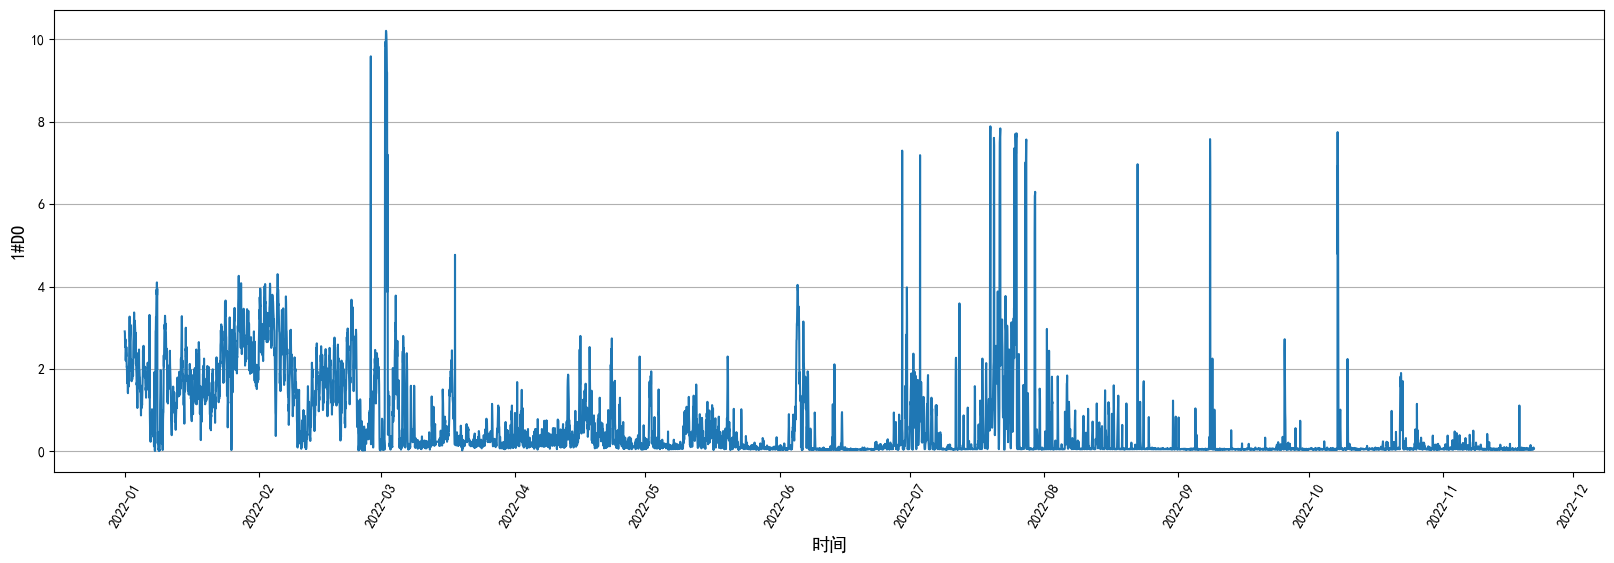

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


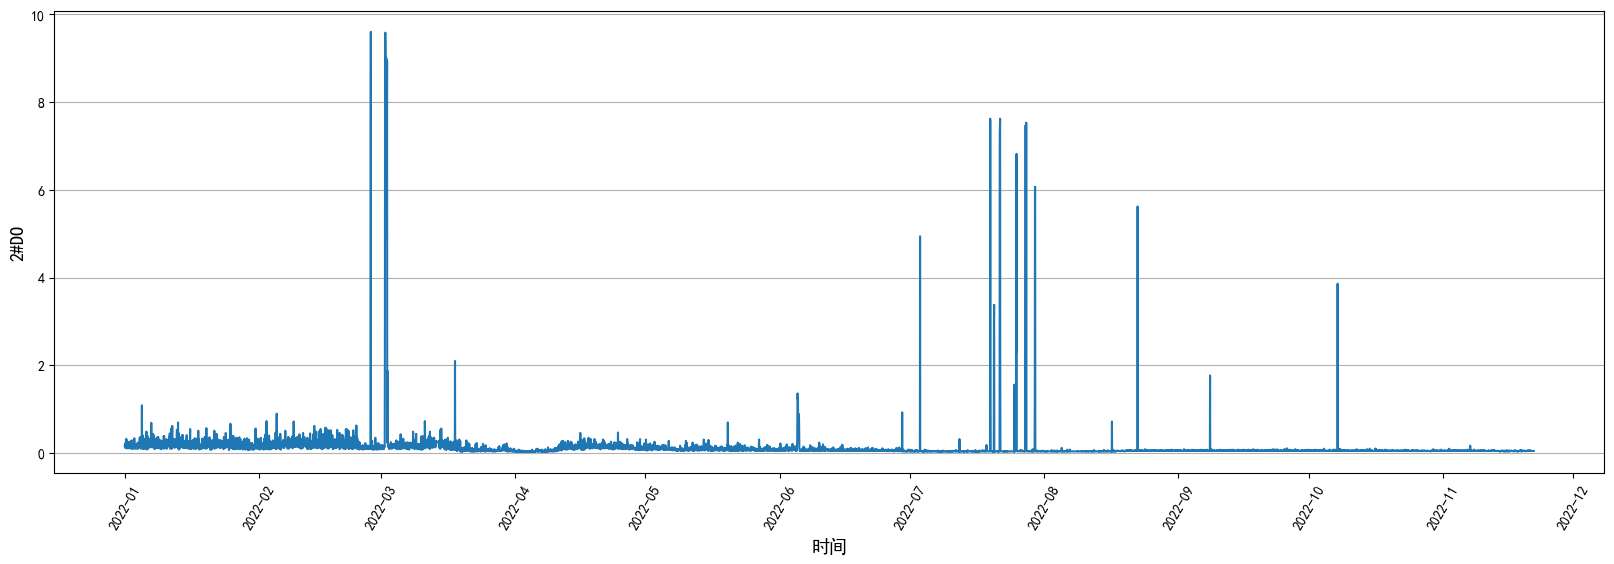

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


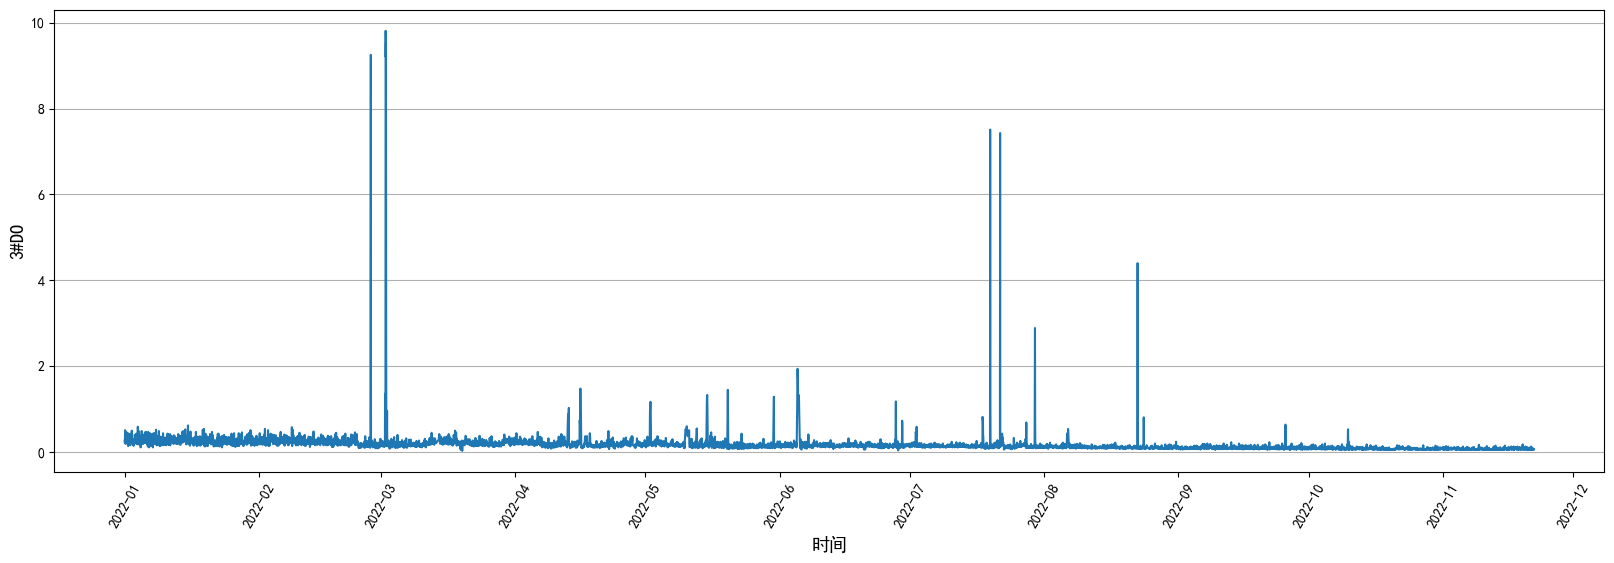

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


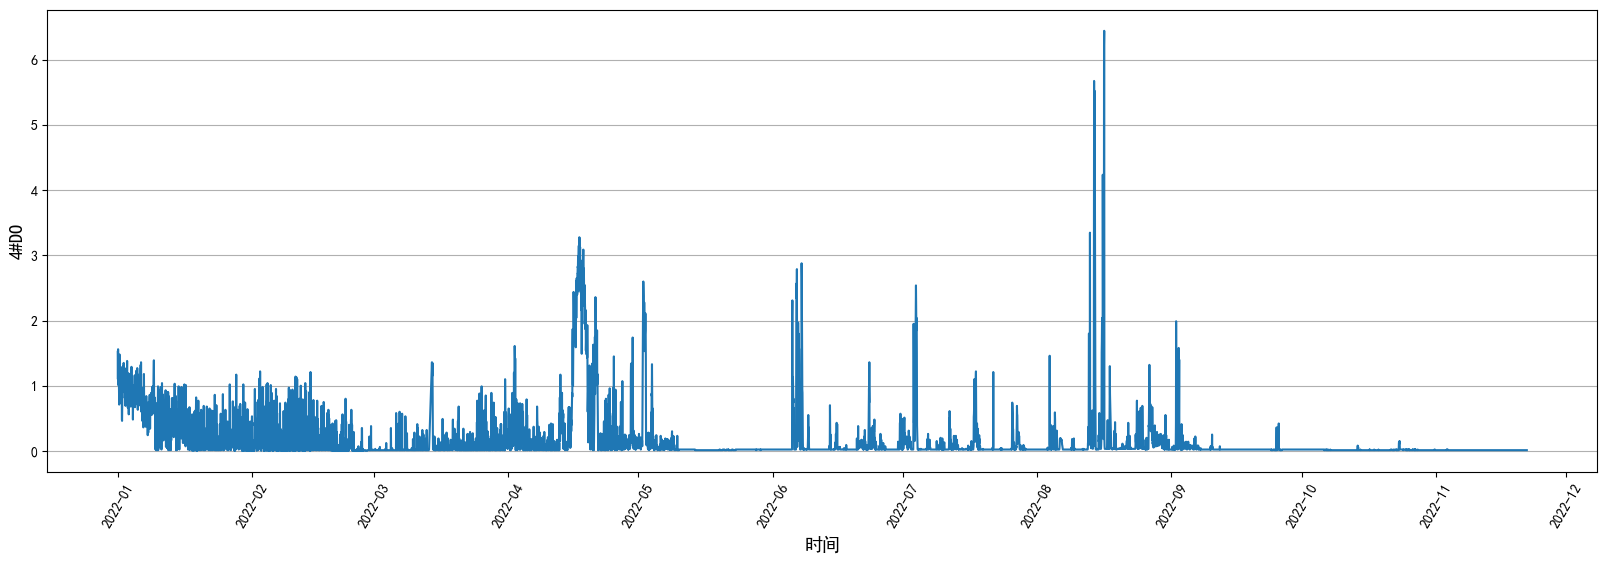

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


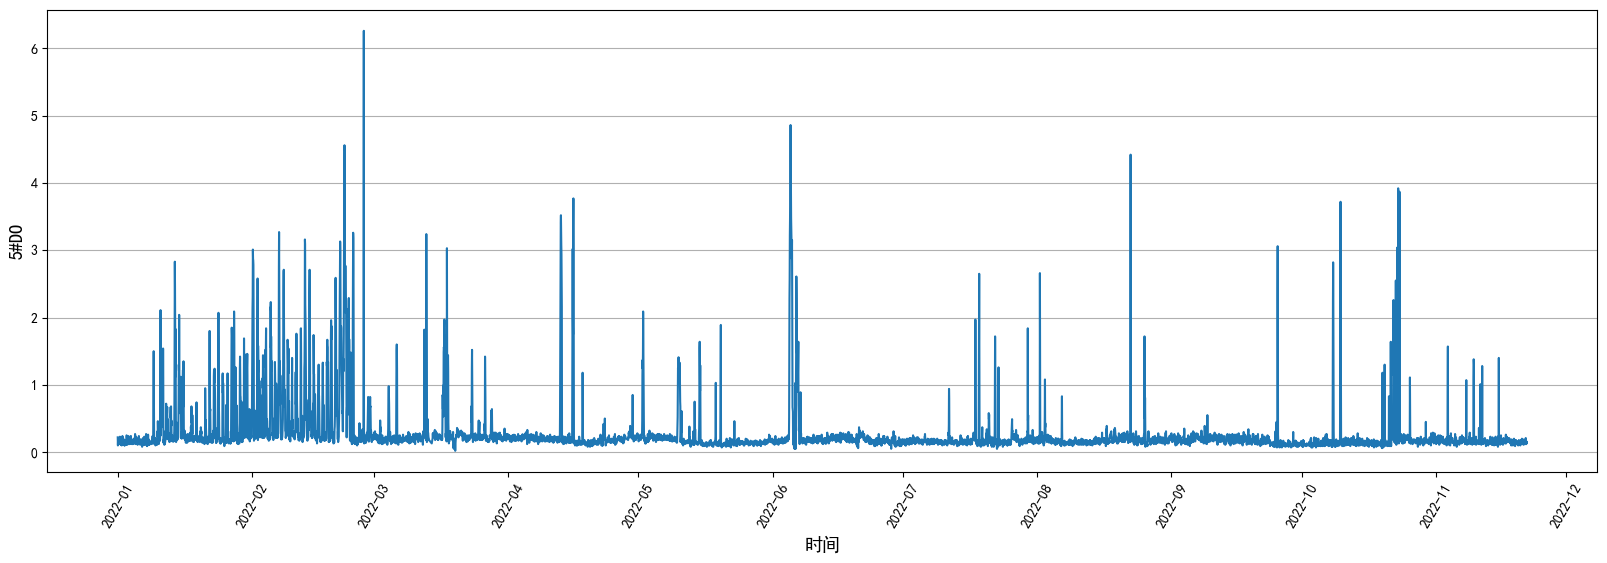

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


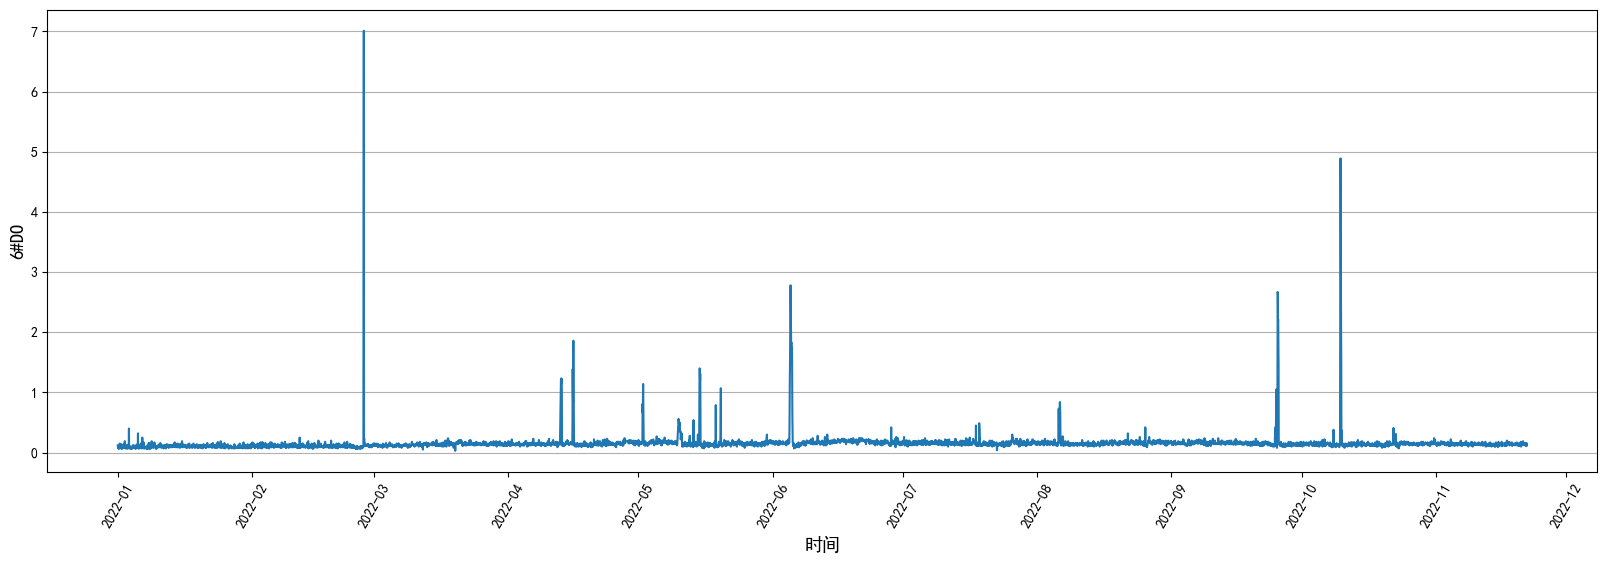

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


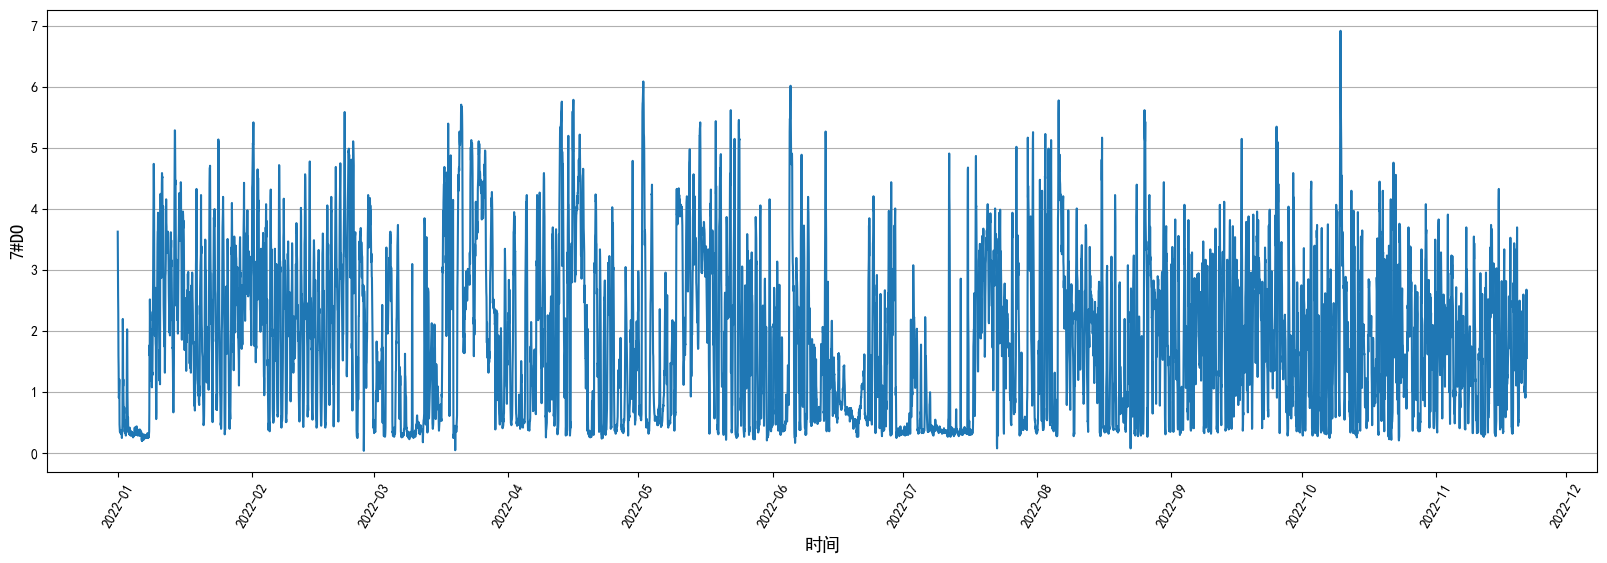

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


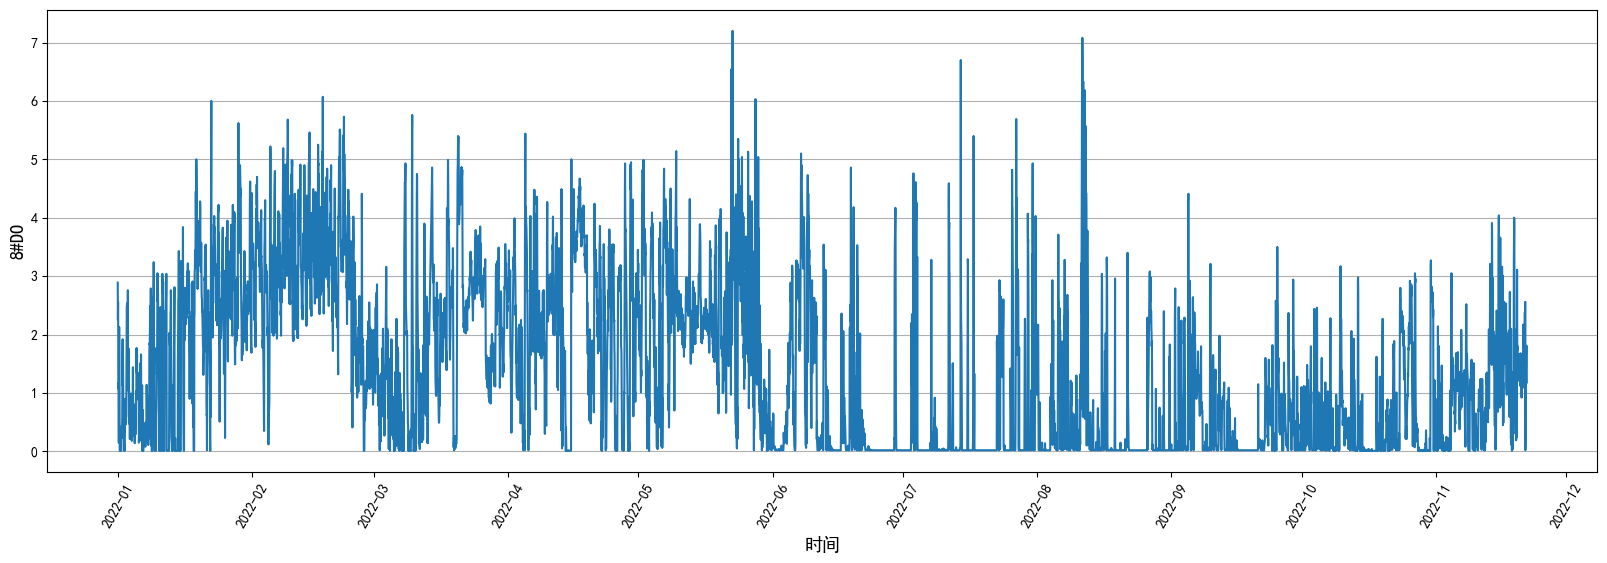

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


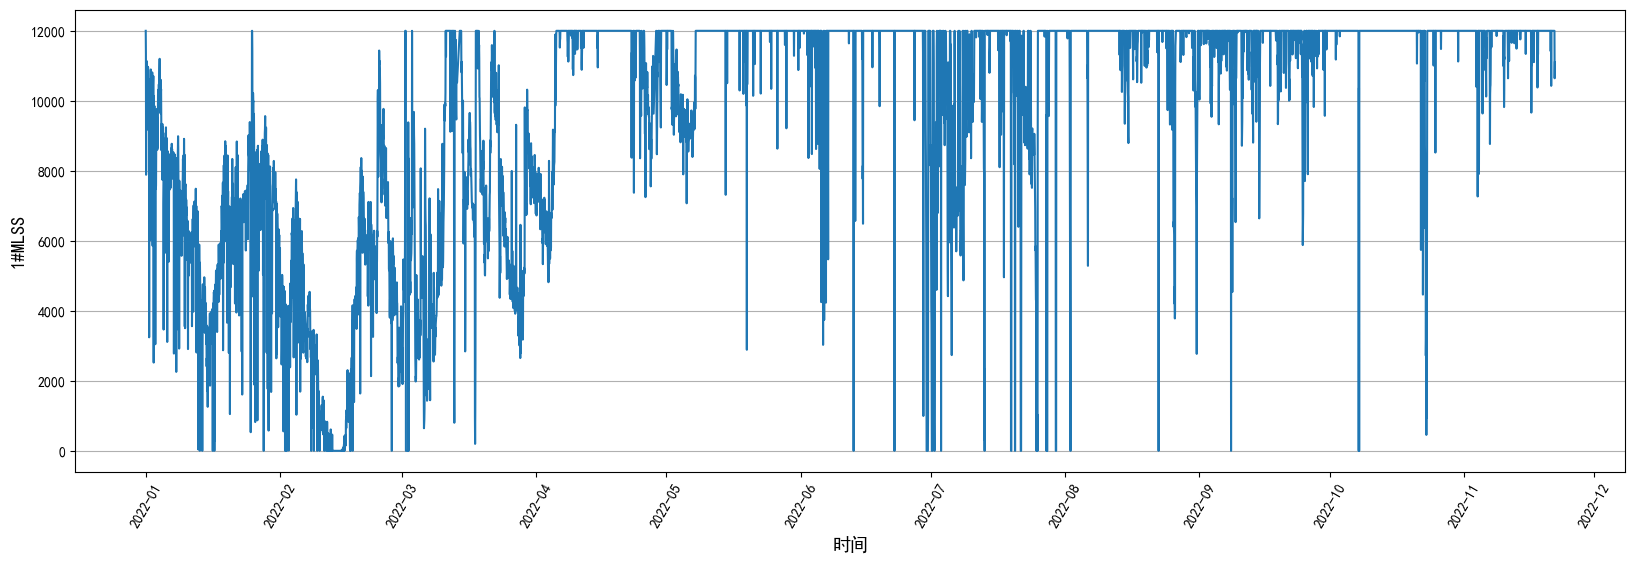

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


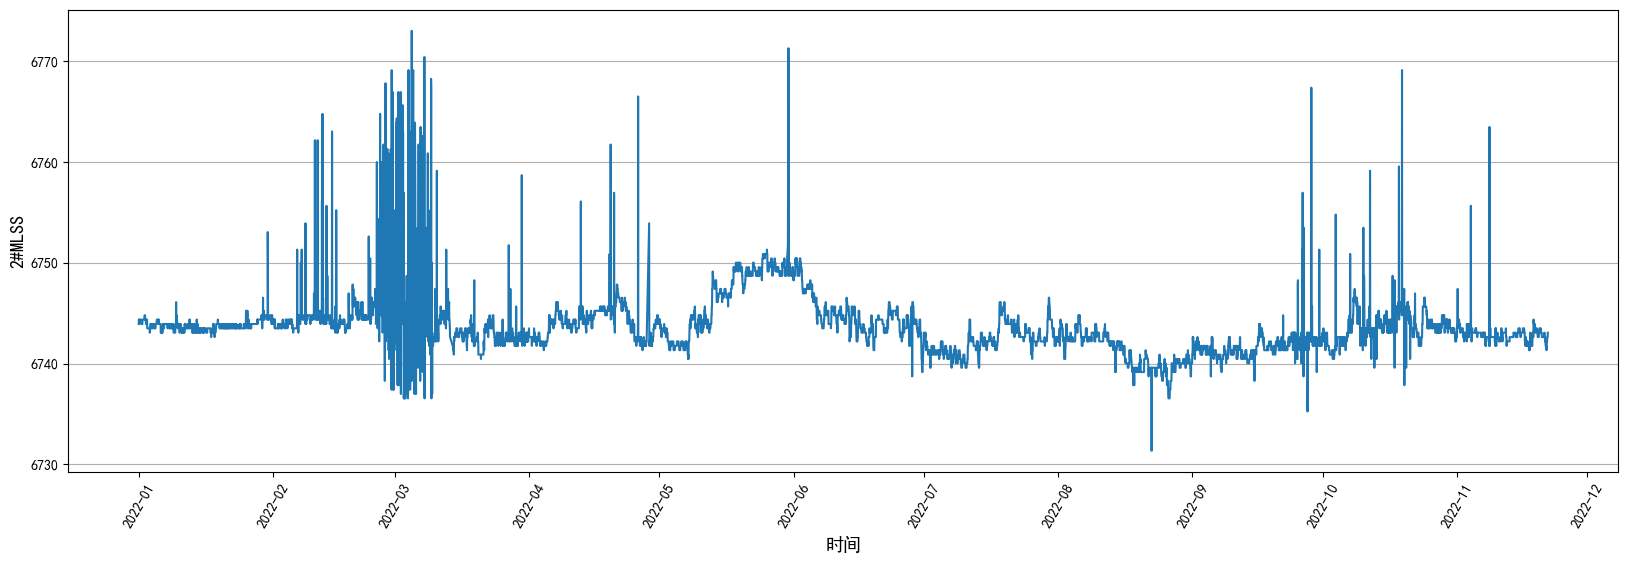

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


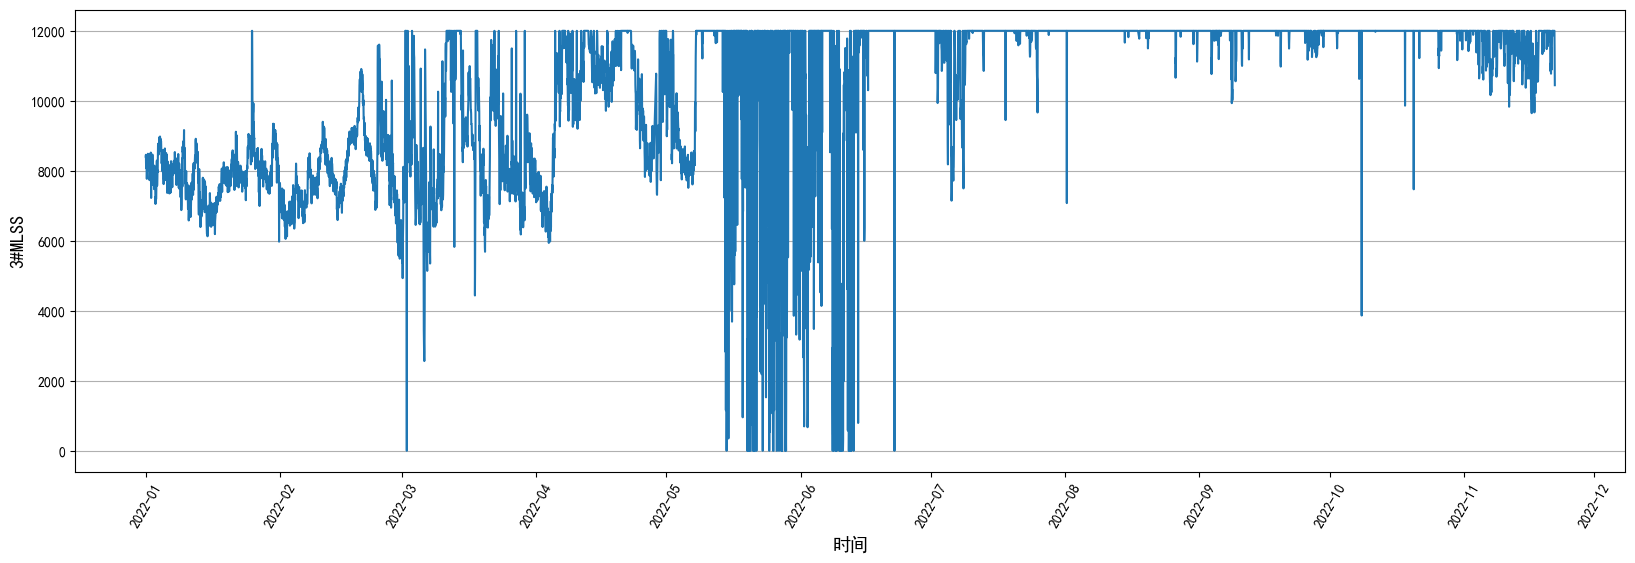

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


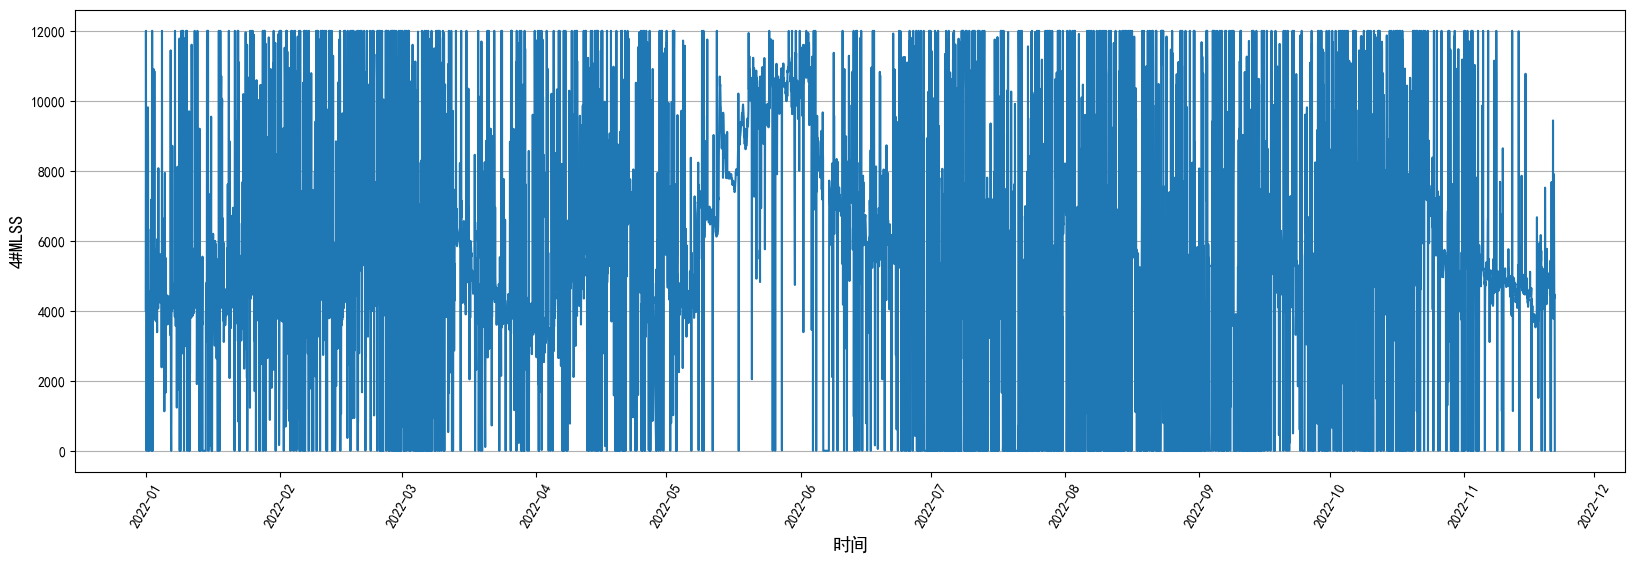

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


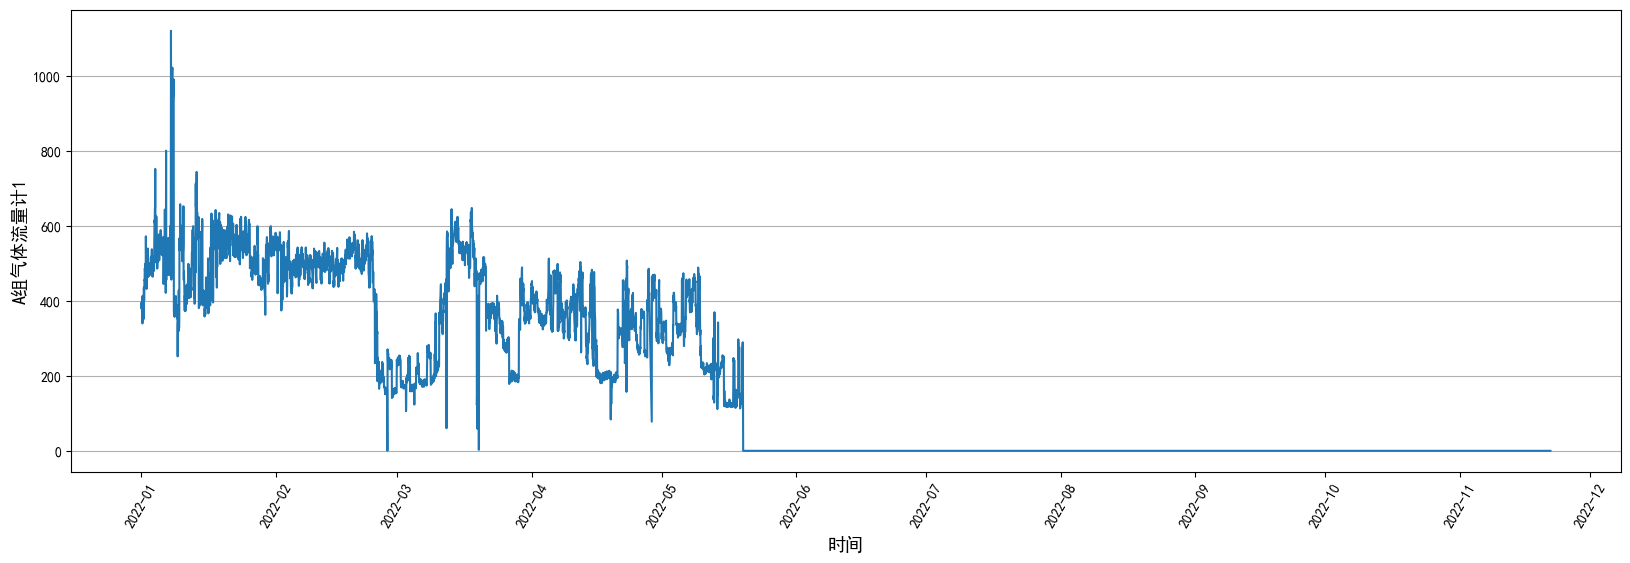

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


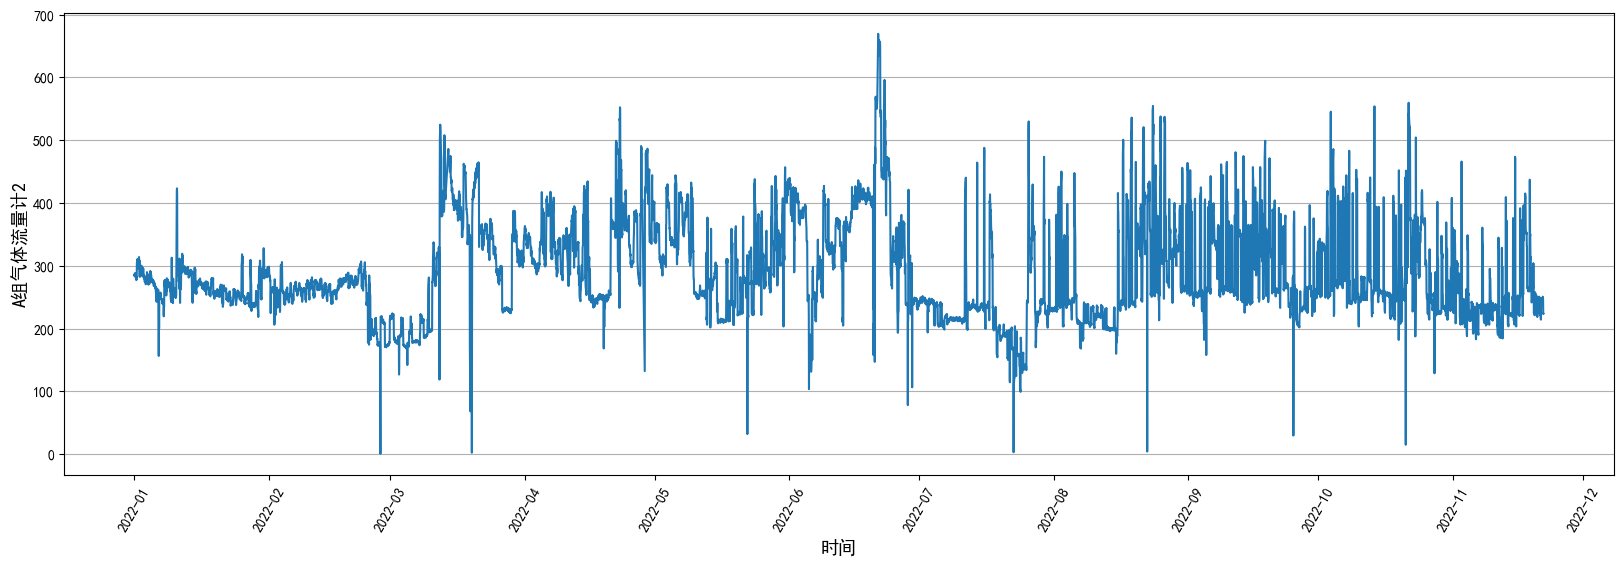

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


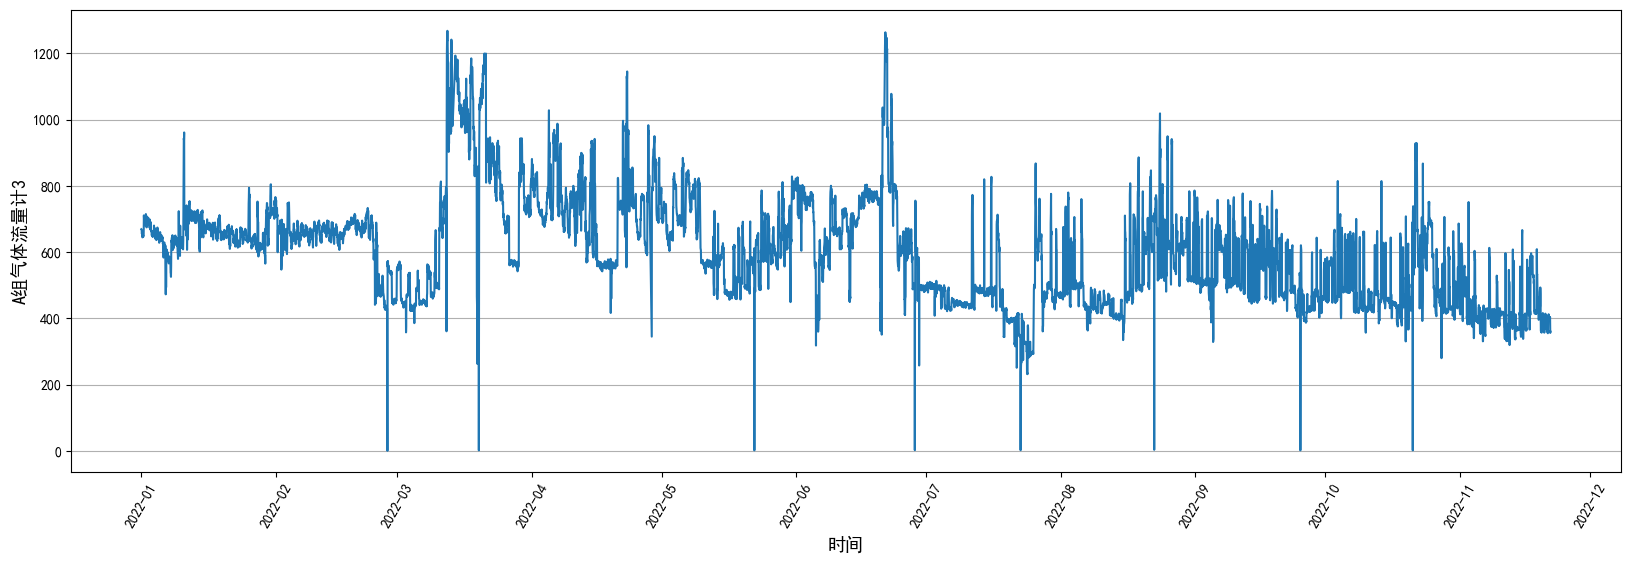

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


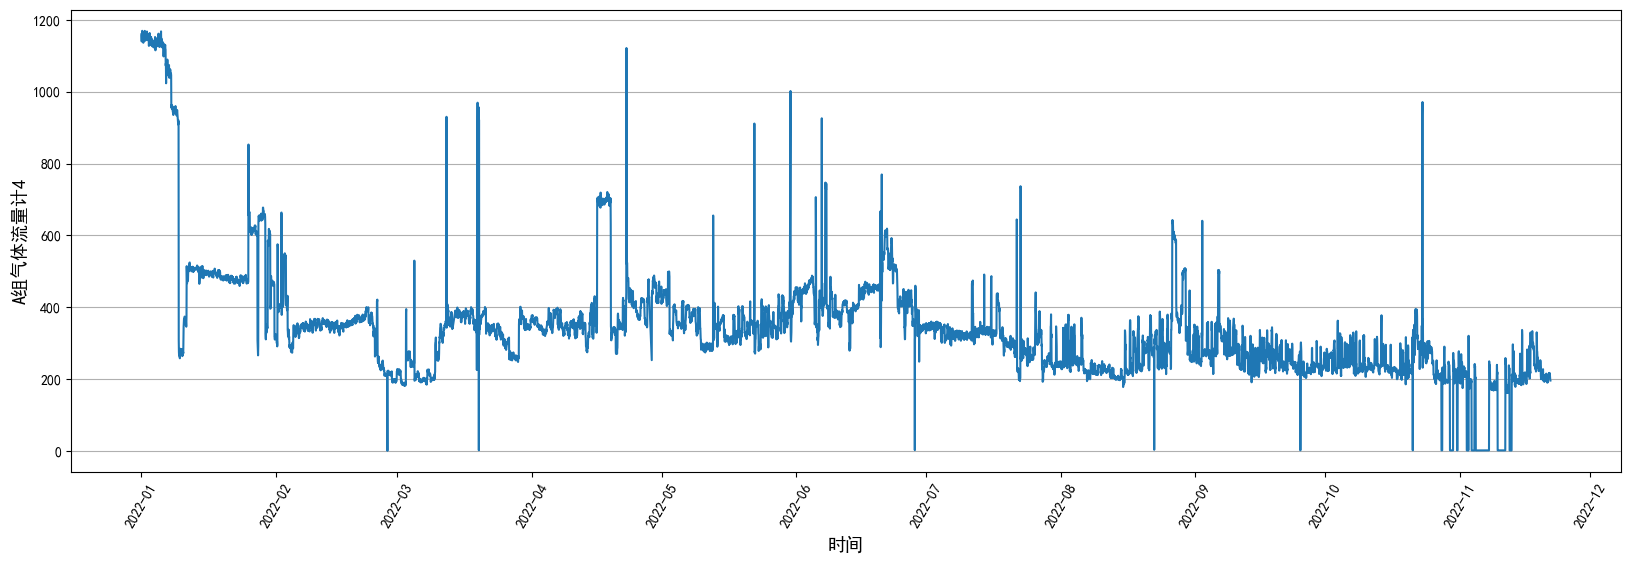

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


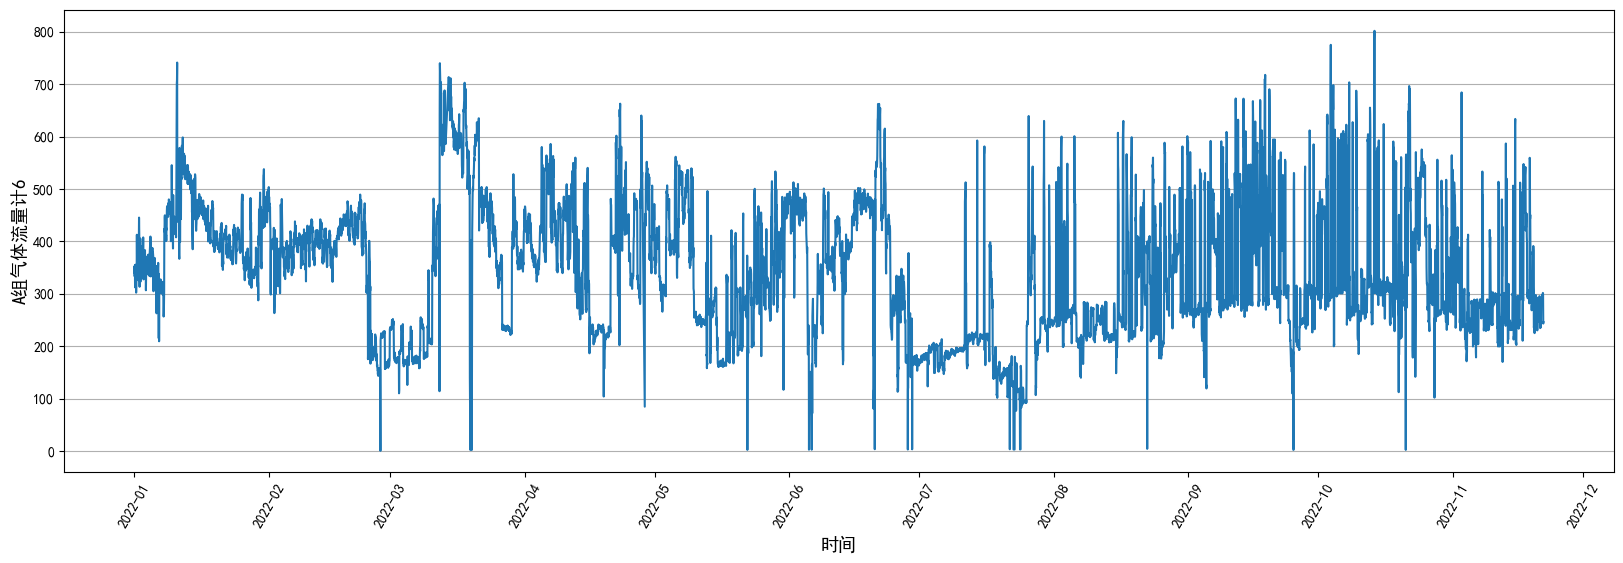

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


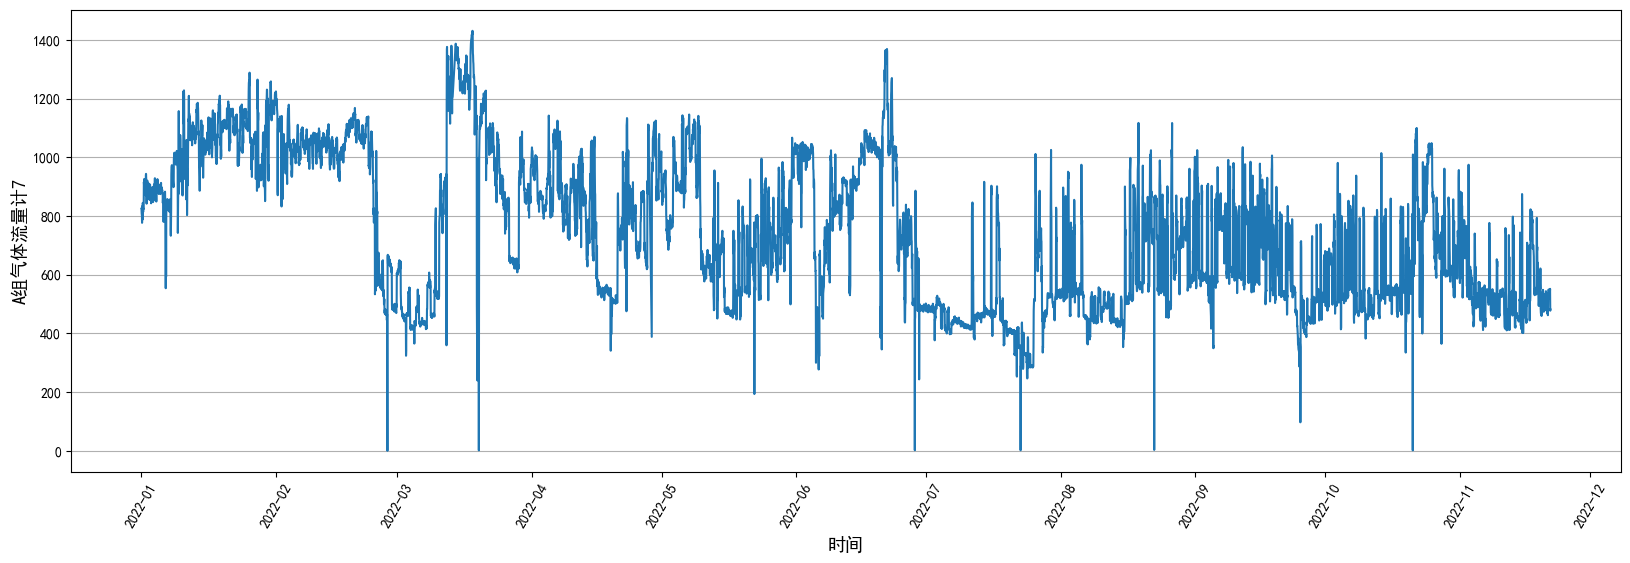

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


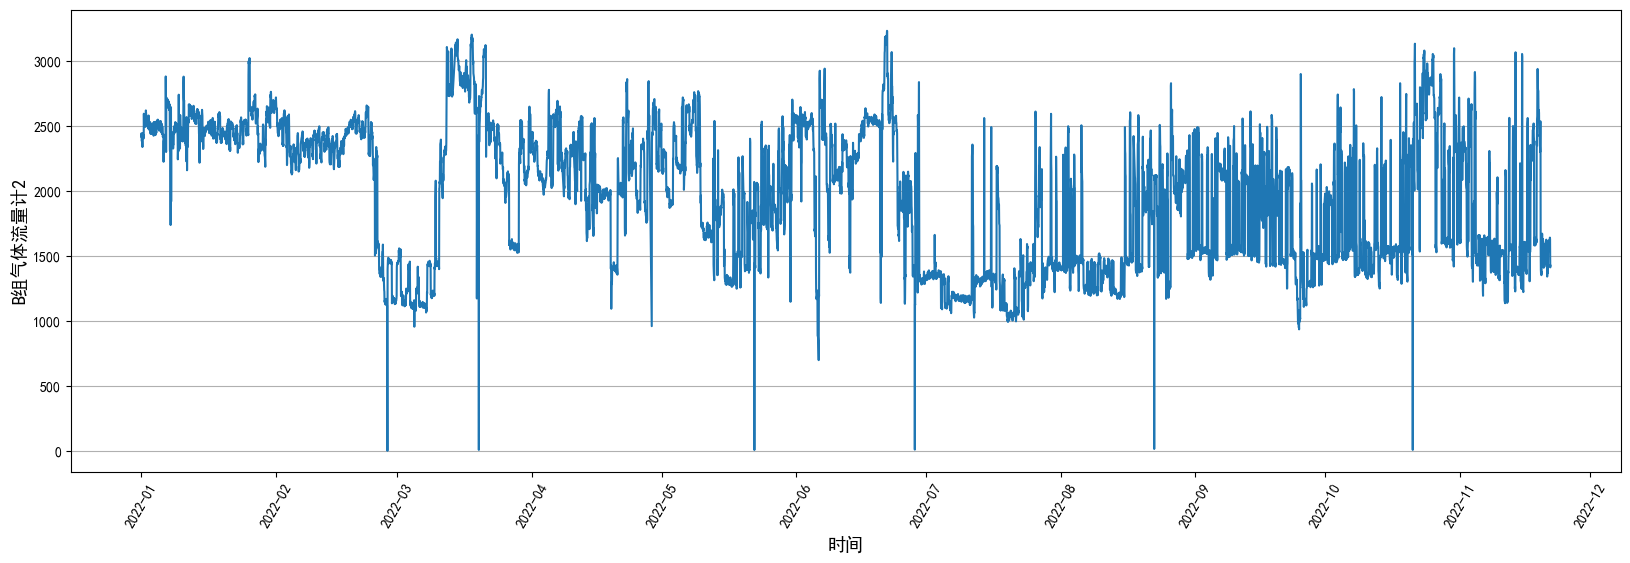

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


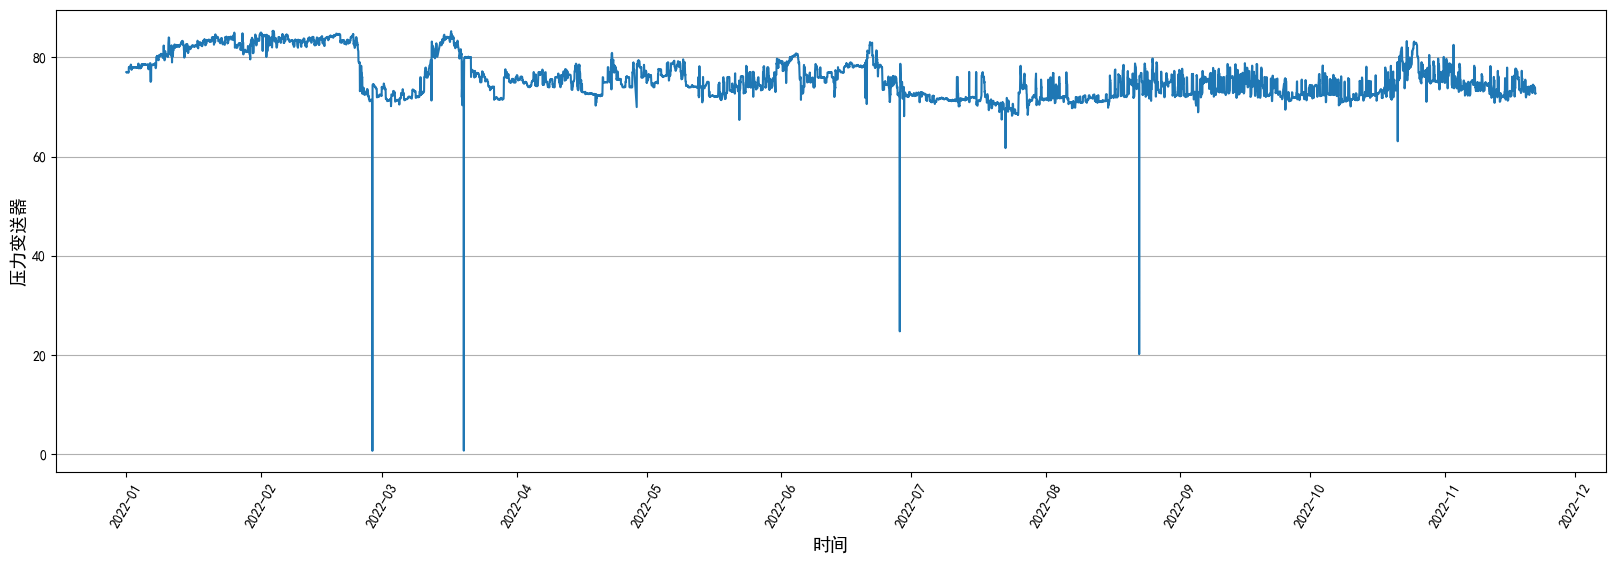

In [9]:
data_vision = df.drop(['时间'],axis=1).columns
x = df['时间']

# 设置字体为黑体，解决Matplotlib中文乱码问题
plt.rcParams['font.sans-serif']=['SimHei']

for name in data_vision:
    y = df[name]
    fig = plt.figure(figsize=(20, 6))
    plt.plot(x, y)
    plt.xlabel('时间',fontsize=13)
    plt.ylabel(name,fontsize=13)
    plt.xticks(rotation=60)  # x轴标签倾斜60度
    plt.legend(loc='best', frameon=False)  # 图例，显示label，去掉边框
    plt.grid(axis="y")
    plt.show()



# 2.数据处理

In [10]:
#  3σ准则检测异常值
def three_sigma(ser):
    '''
    ser参数：被检测的数据，接收DataFrame的一列数据
    返回：异常值及其对应的行索引
    '''
    # 计算平均值
    mean_data=ser.mean()
    # 计算标准差
    std_data=ser.std()
    # 小于μ-3σ或大于μ+3σ的数据均为异常值
    rule=(mean_data-3*std_data > ser) | (mean_data+3*std_data < ser)
    # 然后np.arange方法生成一个从0开始，到ser长度-1结束的连续索引，再根据rule列表中的True值，直接保留所有为True的索引，也就是异常值的行索引
    index=np.arange(ser.shape[0])[rule]
    # 获取异常值
    outliers=ser.iloc[index]
    return outliers
# 对value列进行异常值检测，只要传入一个数据列


In [11]:
# label_list  = three_sigma(df['出水总氮'])
# label_set_list = list(set(label_list))
# df['出水总氮'].replace(label_set_list , NaN , inplace=True)
# df['出水总氮'] = df['出水总氮'].fillna(method='pad')
# label_col = df['出水总氮']

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 47 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   时间        7752 non-null   datetime64[ns]
 1   进水COD     7752 non-null   float64       
 2   进水氨氮      7752 non-null   float64       
 3   进水总磷      7752 non-null   float64       
 4   进水总氮      7752 non-null   float64       
 5   进水SS      7752 non-null   float64       
 6   进水PH      7752 non-null   float64       
 7   进水流量      7752 non-null   float64       
 8   出水COD     7752 non-null   float64       
 9   出水氨氮      7752 non-null   float64       
 10  出水总磷      7752 non-null   float64       
 11  出水总氮      7752 non-null   float64       
 12  出水SS      7752 non-null   float64       
 13  出水PH      7752 non-null   float64       
 14  出水流量      7752 non-null   float64       
 15  1#液位计     7752 non-null   float64       
 16  2#液位计     7752 non-null   float64       
 17  1#ORP     7752

In [13]:
#其他异常值转为缺失值
df_drop_time  = df.drop(['时间'],axis=1)
df_drop_time_and_label   = df_drop_time.drop(['出水总氮'],axis=1)
abnormal_detect_list = df_drop_time_and_label.columns
new_df = df_drop_time_and_label
#需要一个新表
for abnor in abnormal_detect_list:
    ab_list  = three_sigma(df[abnor])
    ab_set_list = list(set(ab_list))
    new_df[abnor].replace(ab_set_list , NaN , inplace=True)



In [14]:
#时间轴处理
#new_df['时间'] = df['时间']
new_df['time'] = pd.to_datetime(df['时间'])
new_df['month'] = new_df['time'].dt.month
new_df['day'] = new_df['time'].dt.day
new_df['hour'] = new_df['time'].dt.hour
new_df['weekday'] = new_df['time'].dt.weekday
new_df['weeknum'] = new_df['time'].dt.isocalendar().week     # 周
new_df['quarter'] = new_df['time'].dt.quarter
#data['minute'] = data['time'].dt.minute
new_df['weeknum'] = new_df['weeknum'].astype('int64')


In [15]:
#数值分桶 

In [16]:
#删除掉  time
new_df  = new_df.drop(['time'],axis=1)
#一般桶树选5~10  这里由于种类较多 选择12 ，如果数值种类数小于100 则暂不分桶 
# 选定不需要分桶的特征列如下
delete_lis = ['出水总磷','2#DO','3#DO','6#DO','2#MLSS','month','day','hour','weekday','weeknum','quarter']
bucket_list = new_df.drop(delete_lis,axis=1).columns
# #等频分箱
# for buc in bucket_list:
#     new_df[buc] = pd.qcut(new_df[buc], 12 ,labels=False , duplicates='drop')
# #等距分箱
# for buc in bucket_list:
#     new_df[buc] = pd.cut(new_df[buc], 12 ,labels=False , duplicates='drop')

In [17]:
#new_df.nunique()

In [18]:
#new_df = new_df.fillna(1e-3)
FeatureEngineer_df = new_df.copy()

# 3. 特征工程

In [19]:
#0.特征分类，虽然都是回归变量，但因为不同类别的计量单位可能都不同，两两交叉之后的意义也不大
inflow_list = ['进水COD','进水氨氮','进水总磷','进水SS','进水总氮','进水PH','进水流量']
outflow_list = ['出水COD','出水氨氮','出水总磷','出水SS','出水总氮','出水PH','出水流量']

##########################################################################

liquidometer_list = ['1#液位计','2#液位计']
ORP_list = ['1#ORP','2#ORP','3#ORP','4#ORP','5#ORP','6#ORP','7#ORP','8#ORP']
DO_list = ['1#DO','2#DO','3#DO','4#DO','5#DO','6#DO','7#DO','8#DO']
MLSS_list = ['1#MLSS','2#MLSS','3#MLSS','4#MLSS']
AB_gas_flowmeter_list = ['A组气体流量计1','A组气体流量计2','A组气体流量计3','A组气体流量计4',
                       'A组气体流量计6','A组气体流量计7','A组气体流量计8','B组气体流量计1','B组气体流量计2']
#B_gas_flowmeter_list = ['B组气体流量计1','B组气体流量计2']


mg_L_list = ['进水COD', '进水氨氮', '进水总磷', '进水总氮', '进水SS', 
             '出水COD', '出水氨氮', '出水总磷', '出水SS']
PH_list = ['进水PH','出水PH']
ll_list = ['进水流量','出水流量']

In [20]:
#1.一阶特征挖掘：rolling滑动窗口：sum、mean、std、min、max

time_list = ['month','day','hour','weekday','weeknum','quarter']
feature_list = FeatureEngineer_df.drop(time_list,axis=1).columns
def roll_feature(fea_data , size):
    for rol_col in feature_list:
        fea_data['roll_sum_'+ rol_col+'_'+ str(size)] = fea_data[rol_col].rolling(size, min_periods=1).sum()
        fea_data['roll_mean_'+ rol_col+'_'+ str(size)] = fea_data[rol_col].rolling(size, min_periods=1).mean()
        fea_data['roll_std_'+ rol_col+'_'+ str(size)] = fea_data[rol_col].rolling(size, min_periods=1).std()
        fea_data['roll_min_'+ rol_col+'_'+ str(size)] = fea_data[rol_col].rolling(size, min_periods=1).min()
        fea_data['roll_max_'+ rol_col+'_'+ str(size)] = fea_data[rol_col].rolling(size, min_periods=1).max()
        
roll_feature(FeatureEngineer_df,4)

In [21]:
FeatureEngineer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Columns: 276 entries, 进水COD to roll_max_压力变送器_4
dtypes: float64(270), int64(6)
memory usage: 16.3 MB


In [22]:
#单独新增一类特征：去除率


# inflow_removal_rate_list = inflow_list[:4]
# outflow_removal_rate_list = outflow_list[:4]

# def get_removal_rate(df_data):
#     for i in range(4):
#         name = inflow_removal_rate_list[i]
#         df_data[name[2:] + '_removal_rate'] = (df_data[name] - df_data[outflow_removal_rate_list[i]])/(df_data[name]+1)
# get_removal_rate(FeatureEngineer_df)            


In [23]:

#2.二阶交叉：和差乘比
def feature_cross_2oder(fea_dataframe , tar_list):
    n = len(tar_list)
    for fir in range(n):
        for sec in range(fir+1,n):
            A = tar_list[fir]
            B = tar_list[sec]
            fea_dataframe[A+'_'+ B +'_sum'] = fea_dataframe[A] + fea_dataframe[B]
            fea_dataframe[A+'_'+ B +'_diff'] = fea_dataframe[A] - fea_dataframe[B]
            fea_dataframe[A+'_'+ B +'_mul'] = fea_dataframe[A] * fea_dataframe[B]
            fea_dataframe[A+'_'+ B +'_ratio'] = fea_dataframe[A] / (fea_dataframe[B] + 1e-3)
            
            
feature_cross_2oder(FeatureEngineer_df , mg_L_list)
feature_cross_2oder(FeatureEngineer_df , PH_list)
feature_cross_2oder(FeatureEngineer_df , ll_list)
feature_cross_2oder(FeatureEngineer_df , liquidometer_list)
feature_cross_2oder(FeatureEngineer_df , ORP_list)
feature_cross_2oder(FeatureEngineer_df , DO_list)
feature_cross_2oder(FeatureEngineer_df , MLSS_list)
feature_cross_2oder(FeatureEngineer_df , AB_gas_flowmeter_list)





In [24]:
FeatureEngineer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Columns: 824 entries, 进水COD to B组气体流量计1_B组气体流量计2_ratio
dtypes: float64(818), int64(6)
memory usage: 48.7 MB


In [25]:
#3.高阶交叉 例如ORP等特征全部求和等

In [26]:

def feature_cross_highoder(fea_high_data , high_list):
    N = len(high_list)
    for ksize in range(3,N+1):
        cur_list = list(combinations (high_list ,ksize))
        for tmp_small in cur_list:
            name_str = ''
            tmp_dataframe = pd.DataFrame({'sum_df':[0]*7752,'mul_df':[1]*7752})
            for meta in tmp_small:
                name_str = name_str + meta + '_'
                tmp_dataframe['sum_df'] = tmp_dataframe['sum_df'] + FeatureEngineer_df[meta]
                tmp_dataframe['mul_df'] = tmp_dataframe['mul_df'] * FeatureEngineer_df[meta]
            FeatureEngineer_df['sum_'+name_str] = tmp_dataframe['sum_df']
            FeatureEngineer_df['mul_'+name_str] = tmp_dataframe['mul_df']


feature_cross_highoder(FeatureEngineer_df , ORP_list)
feature_cross_highoder(FeatureEngineer_df , DO_list)
feature_cross_highoder(FeatureEngineer_df , MLSS_list)
feature_cross_highoder(FeatureEngineer_df , AB_gas_flowmeter_list)
feature_cross_highoder(FeatureEngineer_df , mg_L_list)

    

In [27]:
FeatureEngineer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Columns: 3574 entries, 进水COD to mul_进水COD_进水氨氮_进水总磷_进水总氮_进水SS_出水COD_出水氨氮_出水总磷_出水SS_
dtypes: float64(3568), int64(6)
memory usage: 211.4 MB


In [28]:
#特征筛选降维
from xgboost import XGBRegressor
from xgboost import plot_importance
feat_labels = FeatureEngineer_df.columns
X = FeatureEngineer_df[:6200].values
y = df[:6200]['出水总氮'].values

# fit model no training data
model = XGBRegressor()
model.fit(X , y)
# feature importance

importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 取反后是从大到小
reserve_feature_list = []
for i in range(X.shape[1]):
    #if importances[indices[i]] >= 0.001:
    if len(reserve_feature_list)< 305:
        reserve_feature_list.append(feat_labels[indices[i]])
    else:
        break
    #print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))
    




In [29]:
reserve_feature_list

['sum_4#ORP_5#ORP_7#ORP_8#ORP_',
 'sum_2#ORP_5#ORP_7#ORP_8#ORP_',
 'roll_mean_进水流量_4',
 'mul_2#ORP_5#ORP_7#ORP_',
 'sum_4#ORP_5#ORP_6#ORP_7#ORP_8#ORP_',
 'mul_A组气体流量计2_A组气体流量计4_B组气体流量计1_',
 'mul_进水COD_进水总氮_出水COD_出水氨氮_出水总磷_出水SS_',
 'mul_2#ORP_3#ORP_5#ORP_7#ORP_',
 'A组气体流量计1_A组气体流量计3_diff',
 'sum_2#ORP_3#ORP_7#ORP_8#ORP_',
 'mul_进水COD_进水总磷_进水总氮_出水SS_',
 'sum_3#ORP_6#ORP_8#ORP_',
 '出水总磷_出水SS_diff',
 'A组气体流量计1_A组气体流量计8_sum',
 '进水总氮_出水SS_ratio',
 'roll_min_进水流量_4',
 'mul_1#ORP_2#ORP_3#ORP_4#ORP_',
 'mul_3#ORP_5#ORP_6#ORP_',
 'A组气体流量计3_A组气体流量计8_ratio',
 'mul_2#ORP_5#ORP_8#ORP_',
 'sum_1#ORP_2#ORP_5#ORP_6#ORP_8#ORP_',
 'sum_2#ORP_6#ORP_7#ORP_8#ORP_',
 'weeknum',
 'mul_A组气体流量计4_A组气体流量计7_A组气体流量计8_B组气体流量计2_',
 'mul_2#ORP_3#ORP_4#ORP_5#ORP_8#ORP_',
 'roll_max_7#ORP_4',
 '6#ORP_8#ORP_diff',
 'roll_std_1#MLSS_4',
 'A组气体流量计3_B组气体流量计1_ratio',
 '4#ORP_8#ORP_sum',
 '4#ORP_5#ORP_diff',
 '4#ORP_8#ORP_mul',
 'sum_进水COD_进水氨氮_出水氨氮_',
 '2#ORP_4#ORP_diff',
 'roll_max_2#ORP_4',
 '2#ORP_5#ORP_ratio',
 'mul_进水氨氮

In [30]:

cut_fea = list(set(feat_labels) - set(reserve_feature_list))
FeatureEngineer_df = FeatureEngineer_df.drop(cut_fea,axis=1)


In [31]:
# FeatureEngineer_df = FeatureEngineer_df.fillna(1e-3)
# print(pd.isnull(FeatureEngineer_df.values).any())

In [32]:
FeatureEngineer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Columns: 305 entries, 3#ORP to mul_进水COD_进水总氮_出水COD_出水氨氮_出水总磷_出水SS_
dtypes: float64(302), int64(3)
memory usage: 18.0 MB


In [33]:
TAY = df[:6200]
TEY = df[6200:]
TAY.loc[(TAY['出水氨氮'] >= TAY['出水总氮']),'出水总氮'] = TAY['出水氨氮']
TAY.loc[TAY['出水总氮'] >= 8,'出水总氮'] = 8
TAY.loc[TAY['出水总氮'] <= 1,'出水总氮'] = 1

TEY.loc[(TEY['出水氨氮'] >= TEY['出水总氮']),'出水总氮'] = TEY['出水氨氮']
TEY.loc[TEY['出水总氮'] >= 7,'出水总氮'] = 7
TEY.loc[TEY['出水总氮'] <= 2,'出水总氮'] = 2


# 4.模型交叉训练

In [34]:
#取80%的数据用作训练集，20%的数据用作测试集
#new_df = df.drop(['时间'],axis=1)
# train_data = new_df[:6200]
# test_data = new_df[6200:]

train_data = FeatureEngineer_df[:6200]
test_data = FeatureEngineer_df[6200:]

#train_data_X  = train_data.drop(['出水总氮'],axis=1)
train_data_X  = train_data
train_data_Y = TAY['出水总氮']
#test_data_X  = test_data.drop(['出水总氮'],axis=1)
test_data_X  = test_data
test_data_Y = TEY['出水总氮']

X_train = train_data_X.values  #Creates an array of the train data
X_test = test_data_X.values  #Creates an array of the test data
Y_train = train_data_Y.values 
Y_test = test_data_Y.values


In [35]:
# #XGBoost模型
# xgbmodel = XGBRegressor(random_state=219)
# xgbmodel.fit(X_train, Y_train)
# print("Done")
# predictions_xgb = xgbmodel.predict(X_test)
# print("rmse:", sqrt(mean_squared_error(Y_test, predictions_xgb)))
# print("\nR方_socre为：", r2_score(Y_test, predictions_xgb))

In [36]:
# #LightGBM模型
# lgB_model = LGBMRegressor(random_state=219)
# lgB_model.fit(X_train, Y_train)
# print("Done")
# predictions_lgB = lgB_model.predict(X_test)
# print("rmse:", sqrt(mean_squared_error(Y_test, predictions_lgB)))
# print("\nR方_socre为：", r2_score(Y_test, predictions_lgB))

In [37]:
def lgb_model(clf, train_x, train_y, test_x):
    folds = 10
    seed = 2222
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    #cv_val_pred = np.zeros(train_x.shape[0])
    #cv_scores = []
    test_pre = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i + 1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], \
                                     train_y[valid_index]

        train_matrix = clf.Dataset(trn_x, label=trn_y)
        valid_matrix = clf.Dataset(val_x, label=val_y)

        params = {
            'learning_rate': 0.03,
            'boosting_type': 'gbdt',
            'objective': 'mse',
            'metric': 'mse',
            'verbose': -1,
            'seed': 2020,
            'n_jobs': -1,
            'max_depth': -1,
            'min_child_weight': 4,
            'num_leaves': 2 ** 4,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 4,
        }

        model = clf.train(params, train_matrix, num_boost_round=20000, valid_sets=[train_matrix, valid_matrix],
                          categorical_feature=[], verbose_eval=1000, early_stopping_rounds=200)
        val_pred = model.predict(val_x, num_iteration=model.best_iteration)
        test_pred = model.predict(test_x, num_iteration=model.best_iteration)
        test_pre.append(test_pred)
        print(list(sorted(zip(train_x.columns.tolist(), model.feature_importance()), key=lambda x: x[1], reverse=True))[
              :20])

        #cv_val_pred[valid_index] = val_pred
    #     cv_scores.append(np.sqrt(mean_squared_error(np.expm1(val_y), np.expm1(val_pred))))
    #     #         cv_scores.append(mean_squared_error(val_y, val_pred))
    #     print(cv_scores)
    #
    # print("s_scotrainre_list:", cv_scores)
    # print("s_score_mean:", np.mean(cv_scores))
    # print("s_score_std:", np.std(cv_scores))
    cv_pred = sum(test_pre) / folds

    #return cv_val_pred, cv_pred, np.mean(cv_scores)
    return cv_pred



In [38]:
#lightgbm
pred_lgb = lgb_model(lgb, train_data_X, train_data_Y, test_data_X)
print('***********************************************************************************************')
print('***********************************************************************************************')
print('***********************************************************************************************')
print("rmse:", sqrt(mean_squared_error(Y_test, pred_lgb)))
print("\nR方_socre为：", r2_score(Y_test, pred_lgb))

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds
[1000]	training's l2: 0.051916	valid_1's l2: 0.296722
[2000]	training's l2: 0.0138526	valid_1's l2: 0.260099
[3000]	training's l2: 0.00486121	valid_1's l2: 0.251371
[4000]	training's l2: 0.00194606	valid_1's l2: 0.248012
[5000]	training's l2: 0.000823095	valid_1's l2: 0.246114
Early stopping, best iteration is:
[5455]	training's l2: 0.000564063	valid_1's l2: 0.245596
[('roll_std_出水COD_4', 1014), ('roll_std_4#ORP_4', 951), ('roll_std_出水总磷_4', 907), ('roll_std_进水COD_4', 901), ('roll_sum_4#MLSS_4', 815), ('1#液位计_2#液位计_ratio', 755), ('sum_1#MLSS_2#MLSS_3#MLSS_4#MLSS_', 749), ('出水COD_出水氨氮_diff', 734), ('2#DO_6#DO_mul', 720), ('1#液位计_2#液位计_mul', 698), ('7#DO_8#DO_diff', 643), ('mul_3#DO_4#DO_5#DO_6#DO_8#DO_', 617), ('sum_1#DO_4#DO_5#DO_6#DO_', 615), ('mul_1#DO_2#DO_4#DO_6#DO_', 599), ('roll_mean_3#DO_4', 597), ('roll_std_4#DO_4', 584), ('A组气体流量计3_A组气体流量计6_

[3000]	training's l2: 0.00501212	valid_1's l2: 0.236901
[4000]	training's l2: 0.00199382	valid_1's l2: 0.233066
[5000]	training's l2: 0.000852796	valid_1's l2: 0.231829
[6000]	training's l2: 0.000382145	valid_1's l2: 0.231012
Early stopping, best iteration is:
[5812]	training's l2: 0.000443668	valid_1's l2: 0.230955
[('roll_std_4#ORP_4', 1148), ('roll_std_出水总磷_4', 1115), ('roll_std_出水COD_4', 1079), ('roll_std_进水COD_4', 975), ('roll_sum_4#MLSS_4', 959), ('出水COD_出水氨氮_diff', 940), ('1#液位计_2#液位计_ratio', 867), ('sum_1#MLSS_2#MLSS_3#MLSS_4#MLSS_', 836), ('1#液位计_2#液位计_mul', 782), ('2#DO_6#DO_mul', 742), ('sum_1#DO_4#DO_5#DO_6#DO_', 697), ('7#DO_8#DO_diff', 687), ('A组气体流量计3_A组气体流量计6_diff', 674), ('mul_3#DO_4#DO_5#DO_6#DO_8#DO_', 651), ('mul_2#DO_4#DO_6#DO_8#DO_', 625), ('A组气体流量计3_B组气体流量计1_ratio', 624), ('mul_1#DO_2#DO_4#DO_6#DO_', 620), ('roll_sum_进水总磷_4', 609), ('roll_mean_3#DO_4', 608), ('1#MLSS_4#MLSS_sum', 606)]
************************************ 9 ************************************
Tr

In [31]:
def xgb_model(clf, train_x, train_y, test_x):
    folds = 10
    seed = 2222
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    #cv_val_pred = np.zeros(train_x.shape[0])
    #cv_scores = []
    test_pre = []
    test_matrix = clf.DMatrix(test_x)#, label=trn_y
    
    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i + 1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], \
                                     train_y[valid_index]

        train_matrix = clf.DMatrix(trn_x, label=trn_y)
        valid_matrix = clf.DMatrix(val_x, label=val_y)

        params = {
            'learning_rate': 0.03,
            'boosting_type': 'gbdt',
            'eval_metric' :'rmse',
            'seed': 2020,
            'min_child_weight': 4,
            'num_leaves': 2 ** 4,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 4,
        }

        model = clf.train(params, train_matrix, evals=[(train_matrix, 'Train'), (valid_matrix, 'Valid')]
                          ,num_boost_round=20000,
                           verbose_eval=1000, early_stopping_rounds=200)
        val_pred = model.predict(valid_matrix)
        test_pred = model.predict(test_matrix)
        test_pre.append(test_pred)

        #cv_val_pred[valid_index] = val_pred
    #     cv_scores.append(np.sqrt(mean_squared_error(np.expm1(val_y), np.expm1(val_pred))))
    #     #         cv_scores.append(mean_squared_error(val_y, val_pred))
    #     print(cv_scores)
    #
    # print("s_scotrainre_list:", cv_scores)
    # print("s_score_mean:", np.mean(cv_scores))
    # print("s_score_std:", np.std(cv_scores))
    cv_pred = sum(test_pre) / folds

    #return cv_val_pred, cv_pred, np.mean(cv_scores)
    return cv_pred



In [32]:
#xgboost
pred_xgb = xgb_model(xgb, train_data_X, train_data_Y, test_data_X)
print('***********************************************************************************************')
print('***********************************************************************************************')
print('***********************************************************************************************')
print("rmse:", sqrt(mean_squared_error(Y_test, pred_xgb)))
print("\nR方_socre为：", r2_score(Y_test, pred_xgb))


************************************ 1 ************************************
[14:35:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "bagging_freq", "boosting_type", "feature_fraction", "num_leaves" } are not used.

[0]	Train-rmse:4.11621	Valid-rmse:4.16464
[1000]	Train-rmse:0.14244	Valid-rmse:0.56993
[2000]	Train-rmse:0.05419	Valid-rmse:0.55288
[3000]	Train-rmse:0.02381	Valid-rmse:0.54910
[4000]	Train-rmse:0.01128	Valid-rmse:0.54775
[5000]	Train-rmse:0.00563	Valid-rmse:0.54727
[6000]	Train-rmse:0.00281	Valid-rmse:0.54710
[7000]	Train-rmse:0.00144	Valid-rmse:0.54705
[7569]	Train-rmse:0.00113	Valid-rmse:0.54703
************************************ 2 ************************************
[14:45:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "ba

In [52]:

Pred_BLE = 0.8 * pred_lgb + 0.2 * pred_xgb
print("rmse:", sqrt(mean_squared_error(Y_test, Pred_BLE)))
print("\nR方_socre为：", r2_score(Y_test, Pred_BLE))

rmse: 1.2767119098074498

R方_socre为： 0.181876952207924


# 5.模型集成

In [33]:
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
import numpy as np
from sklearn.ensemble import RandomForestRegressor

level0 = list()
level0.append(('xgb', XGBRegressor()))
level0.append(('gbdt', GradientBoostingRegressor()))
level0.append(('rf', RandomForestRegressor()))

lgbm = LGBMRegressor()

sclf = StackingRegressor(estimators=level0, final_estimator=lgbm, cv=10)

sclf.fit(X_train, Y_train)
Pred = sclf.predict(X_test)

print('***********************************************************************************************')
print('***********************************************************************************************')
print('***********************************************************************************************')
print("rmse:", sqrt(mean_squared_error(Y_test, Pred)))
print("\nR方_socre为：", r2_score(Y_test, Pred))

***********************************************************************************************
***********************************************************************************************
***********************************************************************************************
rmse: 1.468546584157452

R方_socre为： -0.08245104251509328


# 6.模型评估

# 7.模型解释

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


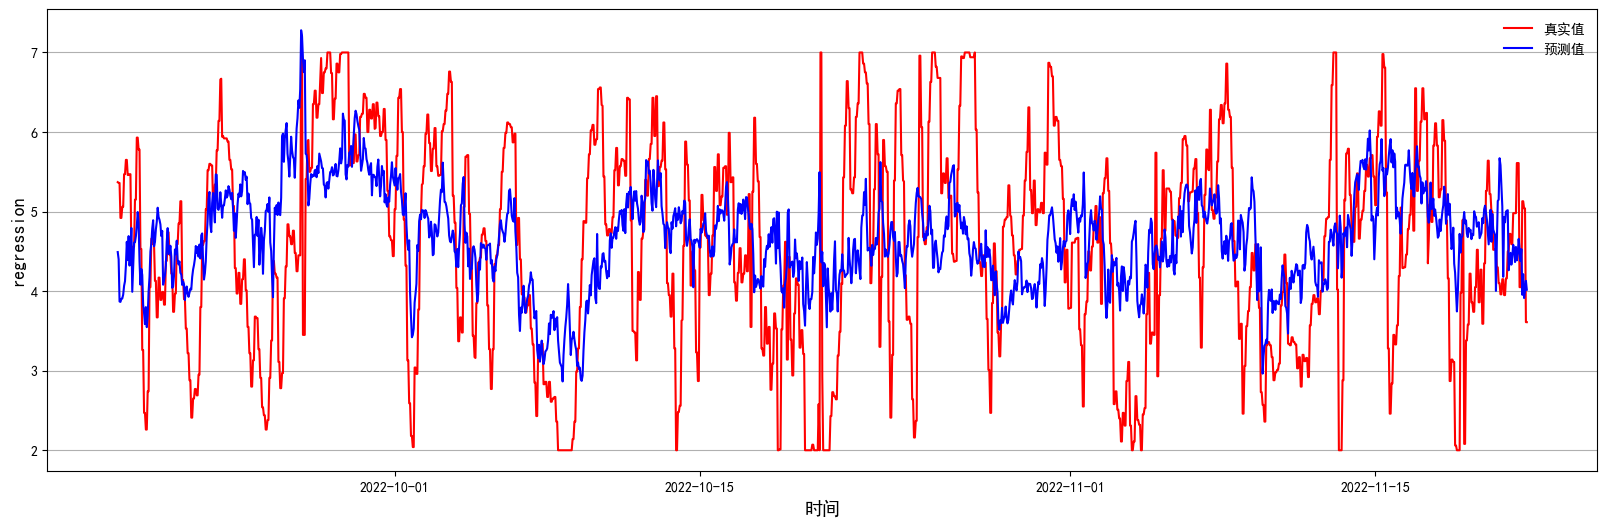

In [39]:
x = df[6200:]['时间']
plt.rcParams['font.sans-serif']=['SimHei']
fig = plt.figure(figsize=(20, 6))
plt.plot(x, Y_test,color='red')
plt.plot(x, pred_lgb,color='blue')
plt.xlabel('时间',fontsize=13)
plt.ylabel('regression',fontsize=13)
plt.legend(loc='best', frameon=False)  # 图例，显示label，去掉边框
plt.legend(labels=['真实值', '预测值'], loc='best',frameon=False) 
plt.grid(axis="y")
plt.show()